# <u><b>0) Prerequisite for this code</b></u>
# 

#### <u><b>Definition of activation booleans and file pathes</b></u> 

In [1]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
installation = False

### Tout ce qui concerne la base de donnée
path_b2d = "../B2D/"

### Tout ce qui concerne les figures
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_figure, path_fig = (
    True,
    "../Figures/"
)

### Tout ce qui concerne le cache des fichiers (pour ne pas avoir à refaire tous les calculs systématiquement)
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_fichiers, path_cache_output = (
    True,
    "../Cache_fichiers/",
)

###### 
#### <u><b>Occasional installation of missing python libraries</b></u> 

In [2]:
if installation :
    !pip install missingno

###### 
#### <u><b>Importation of needed libraries/modules/functions</b></u> 

In [3]:
import numpy as np
import pandas as pd
import missingno as mgno
import matplotlib.pyplot as plt
import seaborn as sns
from re import split
from phik import phik_matrix

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, QuantileTransformer

###### 
#### <u><b>Definition of our own personnal constants</b></u> 

In [5]:
### Freezing randomness of numpy and sklearn with an integer
rgn = 420
np.random.seed(rgn)

# 
# <u><b>I) Exploratory Data Analysis</b></u>
# 

## <u><b>I.A) Discovering datasets</b></u> 
###### 


### <u><b>I.A.1) Loading data</b></u>


Datasets have been uploaded from Kaggle to my own personnal computer. The path to access them is given as the local variable (string) <i>path_fig</i>, defined in the <b>0</b> section.

In [6]:
# Respectively : train set, test set, sample_submission
df_train, df_test, samsub = (
    pd.read_csv(path_b2d + 'train.csv'),
    pd.read_csv(path_b2d + 'test.csv'),
    pd.read_csv(path_b2d + 'sample_submission.csv')    
)

Let's take a quick look at the datasets, loaded as pandas.Datframe. First, the train set :

In [7]:
# Train set
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


We can see there is a mix of categorical, numerical, and boolean features as columns of this Dataframe, including - at last postion as "Transported" - the target vector.

Then, the test set :

In [8]:
# Test set
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


Test set gets about two times less elements than train set. We can see that the last column "Transported" is missing, since WE HAVE to predict its value.

In [9]:
# Sample submission
samsub

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [10]:
samsub['Transported'].value_counts()

False    4277
Name: Transported, dtype: int64

As we can see, this is just the format under which our predictions from test set are expected to be put at the end of this notebook. The fact that the unique value is "False" is just a - pessimistic -  intitialisation.

We will no longer use this variable until our job is done.

###### 
### <u><b>I.A.2) Nature of datasets features</b></u> 


We can now go further into analysis. Let's take a look first at the neature of all parameters of this dataest (features AND target). Please note that we don't use the easiest way - Dataframe.dtypes - since that solution would consider features <i>CryoSleep</i> and <i>VIP</i> as "object" and not "bool", thus making no difference with string features, categorized as "object" as well. 

In [11]:
print('Column\t\tParameter type\n-------------------------------')
for val,col in zip(df_train.loc[0], df_train.columns) :
    print(f'{col : <15}', type(val)) 
del val,col

Column		Parameter type
-------------------------------
PassengerId     <class 'str'>
HomePlanet      <class 'str'>
CryoSleep       <class 'bool'>
Cabin           <class 'str'>
Destination     <class 'str'>
Age             <class 'numpy.float64'>
VIP             <class 'bool'>
RoomService     <class 'numpy.float64'>
FoodCourt       <class 'numpy.float64'>
ShoppingMall    <class 'numpy.float64'>
Spa             <class 'numpy.float64'>
VRDeck          <class 'numpy.float64'>
Name            <class 'str'>
Transported     <class 'numpy.bool_'>


We have :
- 6 quantitative features ;
- 7 categorical features (5 are strings, the 2 remaining are booleans).

This is important to note, because we will have to transform those categorical features into numerical features when algorithm time will come. If the transformation is obvious for booleans (True = 1, False = 0 or -1), string objects might be heavier to deal with, regarding the number of classes per features, and the possible relationships between those classes. As a matter of fact, no ordinal relationship would lead us to use <i>one hot encoding</i>, whereas ordinal or hierarchical relationships would make us prefer using <i>label encoding</i>. In the cas of using <i>one hot encoding</i>, the number of features would increase drastically, which brings back memories of curse of dimensionality, we then should be very carefull, and would have to consider if all features are worth being taken as inputs for the algorithm.

###### 
### <u><b>I.A.3) Missing values</b></u> 


Using graphical functions frm Missingno library, we check how many missing values are hidden within datasets and where. 

C:\Users\luked\anaconda3\envs\oc_iml_p5_01\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


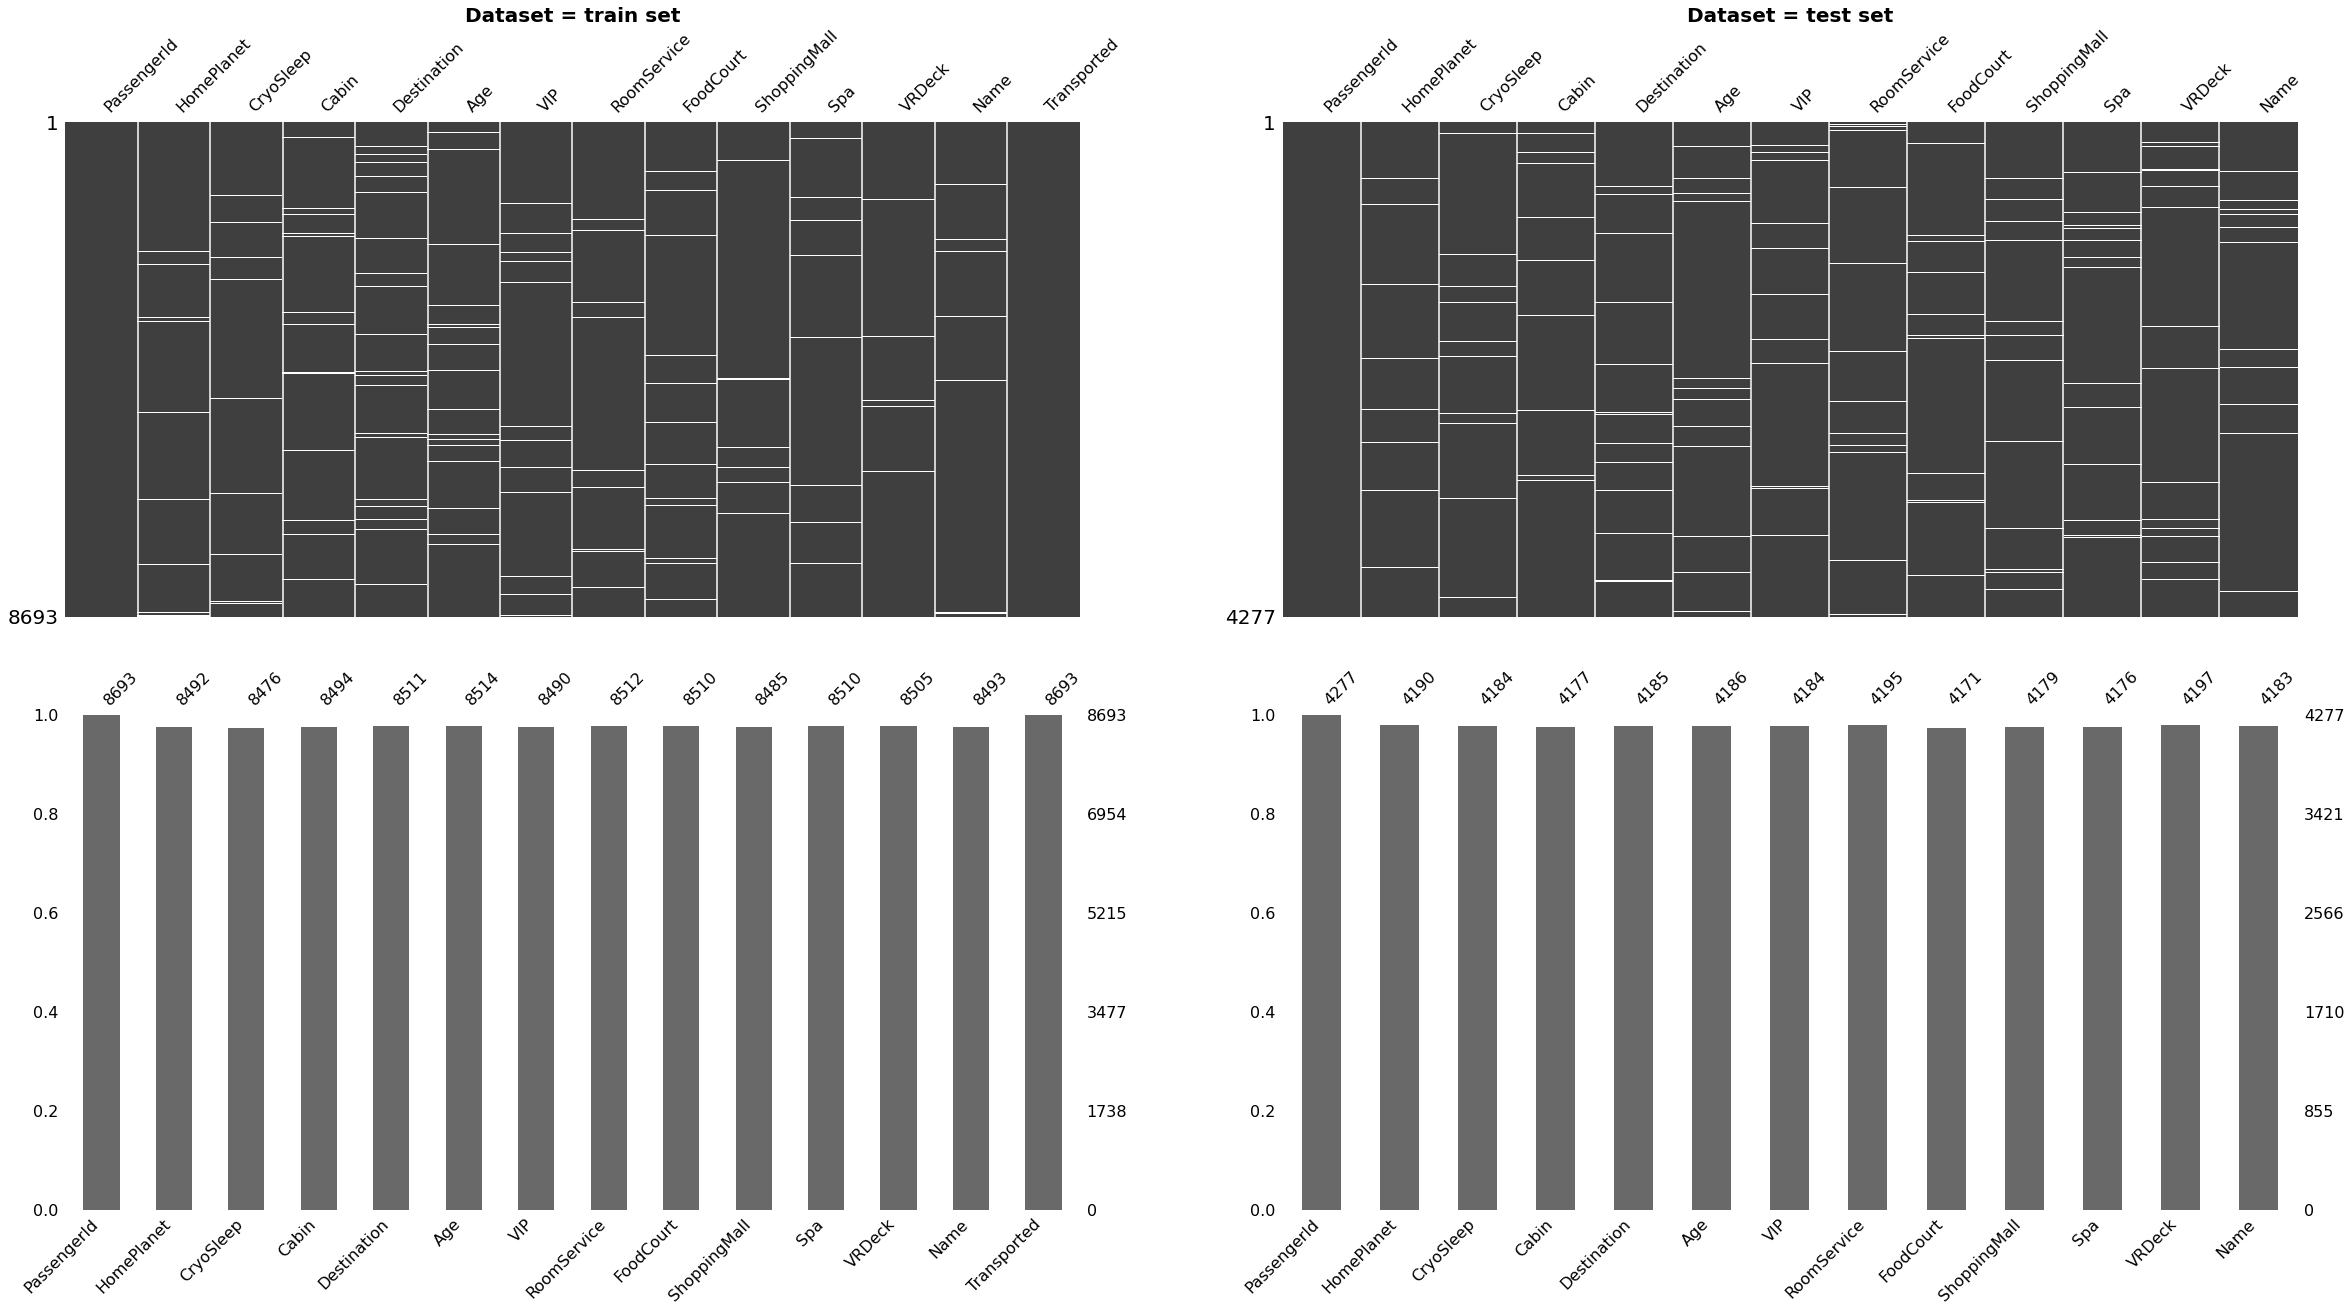

In [12]:
### Ploting bar and matrix diagrams of both train set (lefthand side) and test set (righthand side)
plt.figure('Missing values', figsize=(40,20)), plt.clf()
for i, (df, ds) in enumerate(
    zip([df_train, df_test], ['train','test'])
):
    axe_up, axe_down = plt.subplot(2,2,i+1), plt.subplot(2,2,i+3)
    axe_up.set_title('Dataset = '+ds+' set', weight='bold', fontsize=20)
    mgno.bar(df=df, ax=axe_down), mgno.matrix(df=df, ax=axe_up)
del axe_down, axe_up, i, df, ds

For both datasets, missing values represent never more than few percents of each parameters, with <i>PassengerId</i> and <i>Transported</i> being completely spared bay missing values.

Let's evaluate what would be the impact of cleaning datasets from lines with any missing values, by calculating the percentage of complete lines :

In [13]:
for df, ds in zip([df_train, df_test], ['train','test']):
    df_without_nan = df.dropna(axis=0, how='any')
    print(f'For {ds} set, {len(df_without_nan)/len(df)*100 : .0f}% of rows don`t have any NaN')
del df, df_without_nan, ds

For train set,  76% of rows don`t have any NaN
For test set,  77% of rows don`t have any NaN


We cannot tolerate to lose 23-24% of our rows, considering the initial size of datasets that aren't that big (in such data classification, datasets can easily have hundreds of thousand of inputs).

We conclude that we will HAVE to find a way to fill these values.

######
## <u><b>I.B) Feature engineering (1)</b></u> 
###### 


### <u><b>I.B.1) Concatenating datasets</b></u>


To make the upcomming univariate analysis easier (and then multivariate analysis), we concatenate both train and test dataframes. Furthermore, we create a new column containing the origin of each row (from train ou from test set).

In [14]:
# Concatenation of both datasets, along indexes
df_all = pd.concat([df_train, df_test], ignore_index=True)
# Sorting indexes along PassengerId values
df_all.sort_values(by='PassengerId', inplace=True)
# Adding a column, to know from which dataset the curent line comes
df_all.insert(
    df_train.shape[1],
    'TrainOrTest', 
    ['Test' if np.isnan(val) else 'Train' for val in df_all['Transported']]
             )
# Lets take a look at this global dataset
df_all

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TrainOrTest
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Train
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Train
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Train
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12969,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,Test
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,Train
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,Train
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,Train


We can now erase original datasets to free a bit of space within kernel memory. If necessary, we can still re-upload them quite easily.

In [15]:
del df_train, df_test

###### 
### <u><b>I.B.2) Categorical features cardinality</b></u>


For the reasons written few sections above, we have to check the cardinality of each numerical features, to know what to do of each feature.

In [16]:
print('Column\t\tNumber of unique values\n-------------------------------')
for col in df_all.columns[:-2] :
    if df_all.dtypes[col]=='object' :
        print(f'{col : <10}\t{df_all[col].value_counts().shape[0]}') 
del col

Column		Number of unique values
-------------------------------
PassengerId	12970
HomePlanet	3
CryoSleep 	2
Cabin     	9825
Destination	3
VIP       	2
Name      	12629


As we can read it :
- <i>PassengerId</i> is made of unique values ONLY, it's an identifiant, therfore it sould not been taken as a feature for our future algorithm
- <i>HomePlanet</i>, <i>CryoSleep</i>, <i>Destination</i> and <i>VIP</i> contain an handable number of categories. 

#### <b>We should investigate at least two things</b> :
#### - Why does <i>Name</i>'s cardinality isn't equal to 12970, like <i>PassengerId</i> ? Due to <i>Name</i> meaning, we could expect the feature to be an identifiant as well...
#### - Can we transform <i>Cabin</i> into new features ?

###### 
### <u><b>I.B.3) <i>Name</i> non unique values</b></u>

We create a list of all the names that aren't unique.

In [17]:
names_multiple = list(df_all['Name'].value_counts()[df_all['Name'].value_counts()>1].index)

And we use it to focus on corresponding rows :

In [18]:
df_all[df_all['Name'].apply(lambda x : x in names_multiple)].sort_values(by='Name')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TrainOrTest
2404,2589_01,Europa,True,C/91/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,0.0,Alasmon Meteet,True,Train
9286,1219_02,Europa,True,B/52/S,55 Cancri e,23.0,False,0.0,0.0,0.0,0.0,0.0,Alasmon Meteet,NaN,Test
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True,Train
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False,Train
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,1850_01,Earth,False,F/356/S,PSO J318.5-22,54.0,False,0.0,316.0,257.0,0.0,0.0,Troya Schwardson,False,Train
895,0964_02,Europa,True,B/36/P,TRAPPIST-1e,48.0,False,0.0,0.0,0.0,0.0,0.0,Weidus Platch,True,Train
10002,2808_01,Europa,True,C/95/P,55 Cancri e,30.0,False,0.0,0.0,0.0,0.0,0.0,Weidus Platch,NaN,Test
9037,0739_01,Earth,False,NaN,TRAPPIST-1e,41.0,False,0.0,885.0,0.0,0.0,0.0,Willy Mcfarleys,NaN,Test


It doesn't seem that rows with the same <i>Name</i> value are identical. In fact, those passengers frequently don't even come from the same planet ! 

Let's ensure us that there isn't duplicated rows :

In [19]:
df_all[df_all['Name'].apply(lambda x : x in names_multiple)].sort_values(by='Name').drop_duplicates()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TrainOrTest
2404,2589_01,Europa,True,C/91/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,0.0,Alasmon Meteet,True,Train
9286,1219_02,Europa,True,B/52/S,55 Cancri e,23.0,False,0.0,0.0,0.0,0.0,0.0,Alasmon Meteet,NaN,Test
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True,Train
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False,Train
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,1850_01,Earth,False,F/356/S,PSO J318.5-22,54.0,False,0.0,316.0,257.0,0.0,0.0,Troya Schwardson,False,Train
895,0964_02,Europa,True,B/36/P,TRAPPIST-1e,48.0,False,0.0,0.0,0.0,0.0,0.0,Weidus Platch,True,Train
10002,2808_01,Europa,True,C/95/P,55 Cancri e,30.0,False,0.0,0.0,0.0,0.0,0.0,Weidus Platch,NaN,Test
9037,0739_01,Earth,False,NaN,TRAPPIST-1e,41.0,False,0.0,885.0,0.0,0.0,0.0,Willy Mcfarleys,NaN,Test


The dataset remains unchanged.
#### <b>CONCLUSIONS :</b> We should no longer bother with <i>Name</i> non unique values. We can almost consider <i>Name</i> as an identifioant, and sort this columns out features list. 

###### 
### <u><b>I.B.4) Transforming <i>Name</i> paramater into two new features.</b></u>


Nevertheless, we might be in need to split <i>Name</i> into :
- <i>FirstName</i> ;
- <i>LastName</i>.
Indeed, we had seen that, beyond duplicated names, it seemed to have groups of people with same last name, but different forst names, living in the same cabins, suggesting families. Therefore it might help for filling some missing values in the future, who knows ? 

Let's do it. We will use python library <i>re</i> and all regular expression related functions to do so.

In [20]:
# Transforming a string into a list of 2 strings (or a nan into list of 2 nans)
df_all['Name'] = df_all['Name'].apply(lambda x : split(string=x, pattern=' ') if pd.notna(x) else [np.nan, np.nan])

In [21]:
### Insertion of news columns, one for each aimed feature
# Letter corresponding to the Deck
df_all.insert(13, 'FirstName', df_all['Name'].apply(lambda x : x[0]))
# Letter corresponding to the Side
df_all.insert(14, 'LastName', df_all['Name'].apply(lambda x : x[1]))

In [22]:
# Droping column corresponding to the old Name feature
df_all.drop(axis=1, columns=['Name'], inplace=True)

###### 
### <u><b>I.B.5) Transforming <i>Cabin</i> paramater into several new features.</b></u>

As we saw above, <i>Cabin</i> gets far too many unique values (more than 9000) to be useful in this shape. Indeed, we cannot do one hot encoding on that, this would create uge sparse matrix of numerical features, and be a waste of both computing ressources and time.

The might be a way to figure it out, considering the fact that any value of <i>Cabin</i> take the shape of a <i>deck</i>/<i>num</i>/<i>side</i> (string/integer/string). 

Considering that 
- the position on the 1912 original Titanic was possibly correlated to both social inequalities among passengers, 
- the proximity with lifeboats (specially the position on which deck), 

it may be intersting to split <i>Cabin</i> into 3 features <i>Deck</i>, <i>Num</i> and <i>Side</i> (<i>Deck</i> and <i>Side</i> being categorical with handable numbers of classes), and investigate if those parameters are relevant to be taken account as features for our algorithm.

Let's do it. We will use python library <i>re</i> and all regular expression related functions to do so.

In [23]:
# Transforming a string into a list of 3 strings (or a nan into list of 3 nans)
df_all['Cabin'] = df_all['Cabin'].apply(lambda x : split(string=x, pattern='/') if pd.notna(x) else [np.nan, np.nan, np.nan])

In [24]:
### Insertion of news columns, one for each aimed feature
# Letter corresponding to the Deck
df_all.insert(4, 'Deck', df_all['Cabin'].apply(lambda x : x[0]))
# Integer corresponding to the number of Cabin
df_all.insert(5, 'NumCabin', df_all['Cabin'].apply(lambda x : int(x[1]) if pd.notna(x[1]) else x[1]))
# Letter corresponding to the Side
df_all.insert(6, 'Side', df_all['Cabin'].apply(lambda x : x[2]))

In [25]:
# Droping column corresponding to the old Cabin feature
df_all.drop(axis=1, columns=['Cabin'], inplace=True)

###### 
### <u><b>I.B.6) Transforming <i>PassengerId</i> paramater into two new features.</b></u>


We have read on Kaggle discussion that some people encourage to proceed similarly but to divide <i>PassengerId</i> into two numbers, splitting each value along the undescore.

Let's do it. We will use python library <i>re</i> and all regular expression related functions to do so. We split <i>PassengerId</i> into :
- <i>PId1</i>, first part of <i>PassengerId</i>, left size of the underscore ;
- <i>PId2</i>, second part of <i>PassengerId</i>, right size of the underscore.

In [26]:
### Insertion of news columns, one for each aimed feature
# String corresponding to the first 
df_all.insert(1, 'PId1', df_all['PassengerId'].apply(lambda x : split(string=x, pattern='_')).apply(lambda x : x[0]))
# String corresponding to the 2nd part of PassengerId
df_all.insert(2, 'PId2', df_all['PassengerId'].apply(lambda x : split(string=x, pattern='_')).apply(lambda x : x[1]))

As we did previously, we will drop the initial <i>PassengerId</i> column, but this time, we explicitly conserve this information, copying <i>PassengerId</i> into a new mono-column pandas.Dataframe object before droping it from <i>df_all</i>.

In [27]:
df_pid = df_all['PassengerId'].copy(deep=True)
df_all.drop(axis=1, columns=['PassengerId'], inplace=True)

Please notice that for now, we leave the values taken by these 2 new columns as strings, but that we keep in mind the possibility to turn then to integers later in this notebook, if we think it can be relevant.

In [28]:
print('Column\t\tNumber of unique values\n-------------------------------')
for col in df_all.columns[:2] :
    print(f'{col : <10}\t{df_all[col].value_counts().shape[0]}') 
del col

Column		Number of unique values
-------------------------------
PId1      	9280
PId2      	8


Ok, due to those numbers of unique value, we will HAVE to turn <i>PId1</i> into a numerical feature. For <i>PId2</i>, it's far less urgent, but we decide to do so, in order to anticipate a potential label encoding in the future.

In [29]:
df_all['PId1'] = df_all['PId1'].apply(lambda x : int(x))
df_all['PId2'] = df_all['PId2'].apply(lambda x : int(x))

###### 
### <u><b>I.B.7) Summing the five luxury expenses features to create a supplementary column.</b></u>


In [30]:
df_all.insert(
    15, 
    'TotalExpenses', 
    df_all[
        ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    ].sum(axis=1)
)

#### <u><b>Displaying the dataset after this first step of features engineering</b></u>

In [31]:
df_all

,PId1,PId2,HomePlanet,CryoSleep,Deck,NumCabin,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses,FirstName,LastName,Transported,TrainOrTest
0,1,1,Europa,False,B,0.0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Maham,Ofracculy,False,Train
1,2,1,Earth,False,F,0.0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,736.0,Juanna,Vines,True,Train
2,3,1,Europa,False,A,0.0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,10383.0,Altark,Susent,False,Train
3,3,2,Europa,False,A,0.0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,5176.0,Solam,Susent,False,Train
4,4,1,Earth,False,F,1.0,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1091.0,Willy,Santantines,True,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12969,9277,1,Earth,True,G,1498.0,S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Lilace,Leonzaley,NaN,Test
8689,9278,1,Earth,True,G,1499.0,S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Kurta,Mondalley,False,Train
8690,9279,1,Earth,False,G,1500.0,S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,1873.0,Fayey,Connon,True,Train
8691,9280,1,Europa,False,E,608.0,S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,4637.0,Celeon,Hontichre,False,Train


######
## <u><b>I.C) Univariate EDA.</b></u> 
###### 


### <u><b>I.C.1) Using feature cardinality.</b></u>


Rather than <i>dtype</i>, we will use each features' cardinality to split columns between numerical and categorical features. As a matter of fact, a numerical feature taking very few unique values can be considered as a categorical feature...

In [32]:
print('Column\t\tNumber of unique values\n-------------------------------')
for col in df_all.columns :
    print(f'{col : <10}\t{df_all[col].value_counts().shape[0]}') 
del col

Column		Number of unique values
-------------------------------
PId1      	9280
PId2      	8
HomePlanet	3
CryoSleep 	2
Deck      	8
NumCabin  	1894
Side      	2
Destination	3
Age       	80
VIP       	2
RoomService	1578
FoodCourt 	1953
ShoppingMall	1367
Spa       	1679
VRDeck    	1642
TotalExpenses	2980
FirstName 	2883
LastName  	2406
Transported	2
TrainOrTest	2


Ok, we made our decision, we can explain how we will proceed :
- <i>PId1</i> is left aside, and is not considered as a feature for our future algorithm, due to its very high number of unique values (far more than any other numerical parameter).
- <i>PId2</i>, <i>HomePlanet</i>, <i>CryoSleep</i>, <i>Deck</i>, <i>Side</i>, <i>Destination</i> and <i>VIP</i> are considered as categorical features.
- <i>NumCabin</i>, <i>RoomService</i>, <i>FoodCourt</i>, <i>ShoppingMall</i>, <i>Spa</i> and <i>VRDeck</i> are considered as ordinal features.
- <i>FirstName</i>, <i>LastName</i> and <i>TrainOrTest</i> won't be use as features for the algorithm, but will be used as tool of EDA (at least during multi-variate EDA).
- <i>Transported</i> will be our target, of course.

In [33]:
num_col = ['Age', 'NumCabin', 'TotalExpenses', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_col = ['PId2', 'HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP']

######
### <u><b>I.C.2) Ordinal/numerical features</b></u>


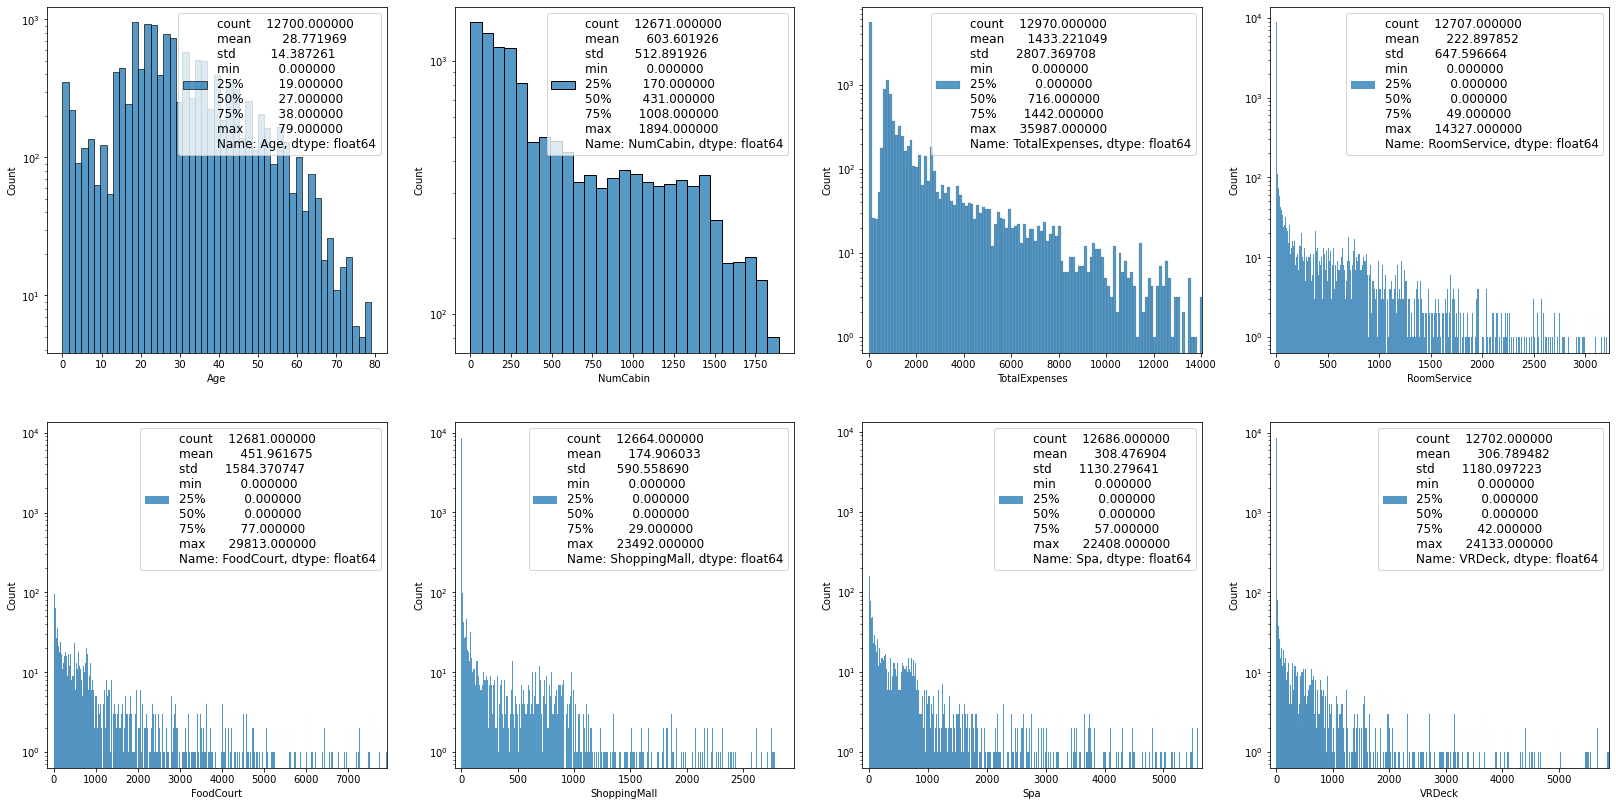

In [34]:
plt.figure('UV EDA, num features', figsize=(28, 14)), plt.clf()
for i, col in enumerate(num_col):
    axe1 = plt.subplot(2,4,i+1)
    sns.histplot(data=df_all, x=col, ax=axe1, log_scale=(False, True), label=str(df_all[col].describe()))
    axe1.legend(loc='best', fontsize=12)
    if df_all[col].std()>1.5*df_all[col].mean() :
        axe1.set_xlim([-0.1*df_all[col].std(), 5*df_all[col].std()])
del i, col, axe1,

Those features take distribution overwhelmed by one mode, which dwells among low taken values (please notice that the y-axis is log scaled to emphasis high range taken values whose counts are really low). This is especially true the five luxury expenses features (<i>RoomService</i>, <i>FoodCourt</i>, <i>ShoppingMall</i>, <i>Spa</i> and <i>VRDeck</i>), for whom 0 is by far the most frequently taken value :

In [35]:
print('Column\t\tMost freq.\tOccurences',
      '\n----------------------------------------------------')
for col in df_all[num_col] :
    print(f'{col : <10}\t{df_all[col].value_counts().index[0]}\t\t{df_all[col].value_counts()[0]}') 
del col

Column		Most freq.	Occurences 
----------------------------------------------------
Age       	18.0		260
NumCabin  	82.0		25
TotalExpenses	0.0		5457
RoomService	0.0		8303
FoodCourt 	0.0		8146
ShoppingMall	0.0		8331
Spa       	0.0		7935
VRDeck    	0.0		8252


The important imbalance between std and mean should push us to expect potential non linear correlations betweens thos features and the target. It may be advise in the future to do some feature pre-processing to work with less biaised distributions.

It would interesting to draw the univariate distribution of the sum of these five last features, to see how the overwhelming importance of 0 is reduced.

It's better, even if 0 is alway the most frequently taken values. We can see that the median is now a non nul value, and that the ration std/mean has decreased to be now around 2, as regard of higher values of ration for the initial five distribution. 

We should consider in the future taking this sum as a supplementary feature for our algorithm. Further analysis should help us decide if taking this new feature :
- in addition to 
- inspite of 

the five type of original luxury expenses.

At last, we must check if the univariate distributions remain approximatively identical bewteen train and test sets. We use groupby and describe functions to do so, focusing on mean, std and median of each feature.

In [36]:
df_all.groupby('TrainOrTest')[num_col].describe(percentiles=[]).drop(
    axis=1, level=1, columns=['count', 'min', 'max', 'mean']
)

Age          NumCabin        TotalExpenses         \
                   std   50%         std    50%           std    50%   
TrainOrTest                                                            
Test         14.179072  26.0  514.968131  442.0   2816.402100  714.0   
Train        14.489021  27.0  511.867226  427.0   2803.045694  716.0   

            RoomService         FoodCourt      ShoppingMall               Spa  \
                    std  50%          std  50%          std  50%          std   
TrainOrTest                                                                     
Test         607.011289  0.0  1527.663045  0.0   560.821123  0.0  1117.186015   
Train        666.717663  0.0  1611.489240  0.0   604.696458  0.0  1136.705535   

                       VRDeck       
             50%          std  50%  
TrainOrTest                         
Test         0.0  1246.994742  0.0  
Train        0.0  1145.717189  0.0

That's the case, we can't find any significant difference between the two sets.

######
### <u><b>I.C.3 Categorical features</b></u>


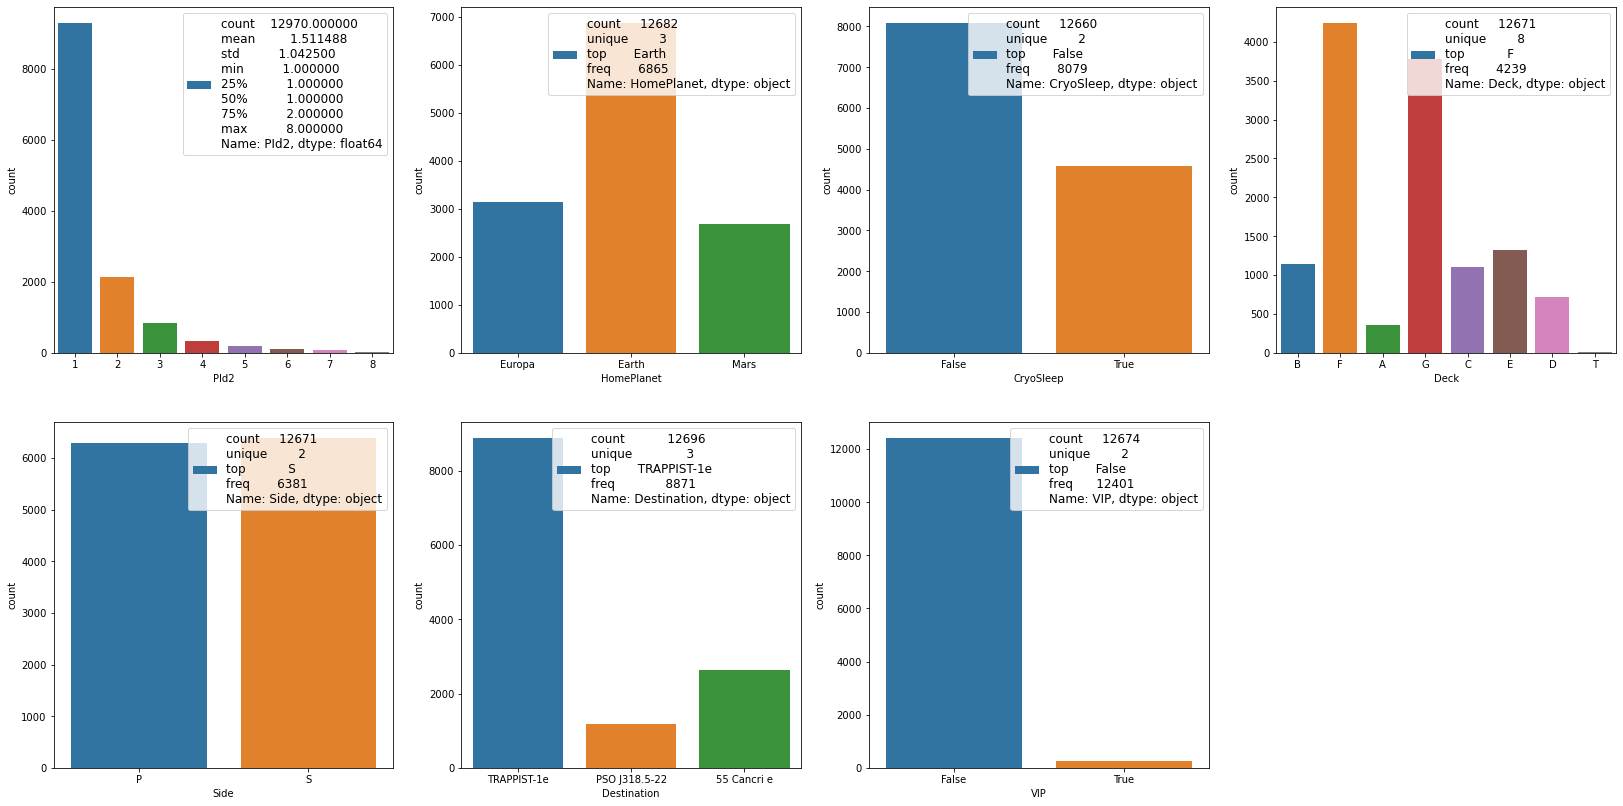

In [37]:
plt.figure('UV EDA, cat features', figsize=(28, 14)), plt.clf()
for i, col in enumerate(cat_col):
    axe1 = plt.subplot(2,4,i+1)
    sns.countplot(data=df_all, x=col, ax=axe1, label=str(df_all[col].describe()))
    axe1.legend(loc='best', fontsize=12)
del i, col, axe1,

Contrary to ordinal features' case, we have a lot of different situations for categorical features' distributions :
- <i>PId2</i> sees its taken values' counts decreasing with the actual taken value, 1 being the first and overwhelming mode.
- <i>HomePlanet</i> takes the value <i>Earth</i> about one out of two, each <i>Europa</i> and <i>Mars</i> counting for approximatively 25% of the occurences, which means that <i>HomePlanet</i>'s distribution is inballanced, but it remains sufficent in term of well representation of each value.
- Same situation for the boolean <i>CryoSleep</i>, <i>False</i> counting for ~2/3 of the occurences.
- <i>Deck</i> has two principal mode (<i>F</i> and <i>G</i>, counting together for 66% of the occurences), and on the other hand, one categorie is almost not represented (<i>T</i>) 
- <i>Side</i> is almost perfectly ballanced between its two taken value.
- <i>Destination</i> starts being very inballanced, even betwenn the two less frequently taken value.
- <i>VIP</i> is the most inballanced features of all categorical features, to the point where we could start having doubts about its utility as a feature.

We can conclude that, in term of handable distributions :
- <i>HomePlanet</i>, <i>CryoSleep</i> and <i>Side</i> are good features to provide for classification.
- <i>PId2</i>, <i>Deck</i> and <i>Destination</i> might need further transformations to lessen their inballances (for example : considering all unfreqently taken values as one single more frequently taken value).
- <i>VIP</i> is a terrible feature, maybe we should just drop it out of the features list.

At least, those inballances are proportionnaly the same between train and test set :

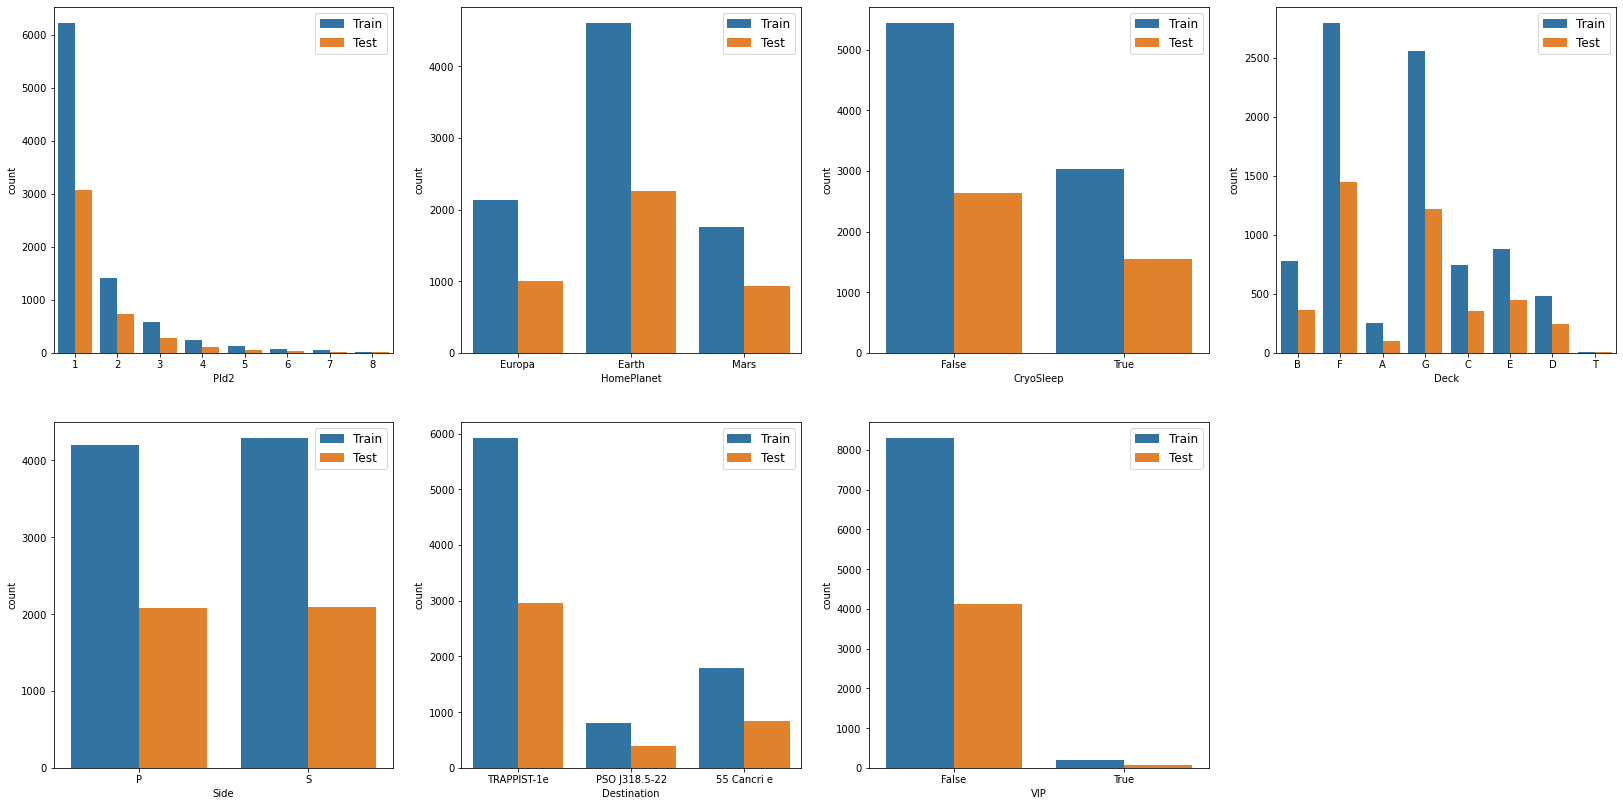

In [38]:
plt.figure('UV EDA, cat features, hue train test', figsize=(28, 14)), plt.clf()
for i, col in enumerate(cat_col):
    axe1 = plt.subplot(2,4,i+1)
    sns.countplot(data=df_all, x=col, ax=axe1, hue='TrainOrTest')
    axe1.legend(loc='best', fontsize=12)
del i, col, axe1,

######
## <u><b>I.D) Multi-variate EDA.</b></u> 
###### 


### <u><b>I.D.1) Phi-K correlation</b></u>


In [39]:
phik_corr_matrix = df_all[df_all['TrainOrTest']=='Train'].drop(
    axis=1,columns=['TrainOrTest', 'PId1', 'FirstName','LastName']
).phik_matrix().round(2)

interval columns not set, guessing: ['PId2', 'NumCabin', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalExpenses']


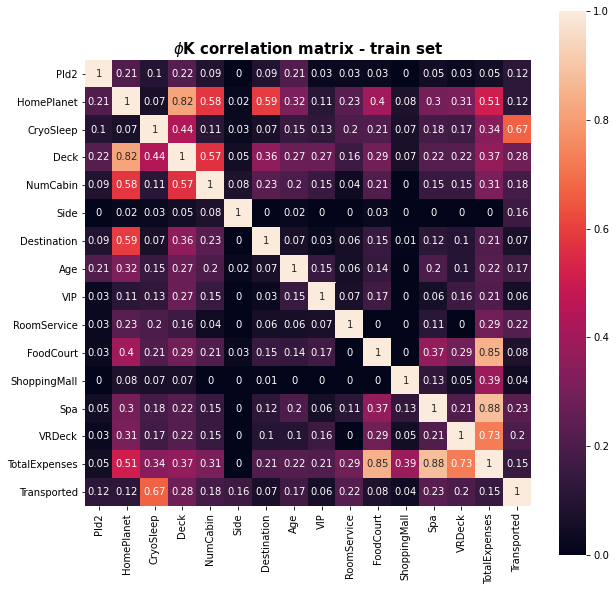

In [40]:
plt.figure('PhiK CorrMatrix - train set', figsize=(10,10)), plt.clf()
axe1 = plt.subplot(111)
axe1.set_title(r'$\phi$K correlation matrix - train set', fontsize=15, fontweight='bold')
sns.heatmap(phik_corr_matrix, cbar=True, square=True, annot=True, ax=axe1)
del axe1

###### 
### <u><b>I.D.2) Focussing on <i>Transported</i></b></u>


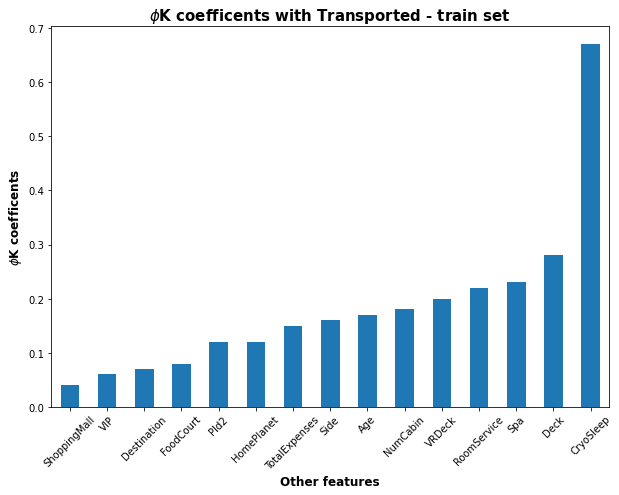

In [41]:
plt.figure('PhiK correlation coefficients with Transported', figsize=(10,7)), plt.clf()
axe1 = plt.subplot(111)
axe1.set_title(r'$\phi$K coefficents with Transported - train set', fontsize=15, fontweight='bold')
axe1.set_ylabel(r'$\phi$K coefficents', fontsize=12, fontweight='bold'), axe1.set_xlabel('Other features', fontsize=12, fontweight='bold')
phik_corr_matrix['Transported'][:-1].sort_values().plot.bar(ax=axe1, rot=45)
del axe1

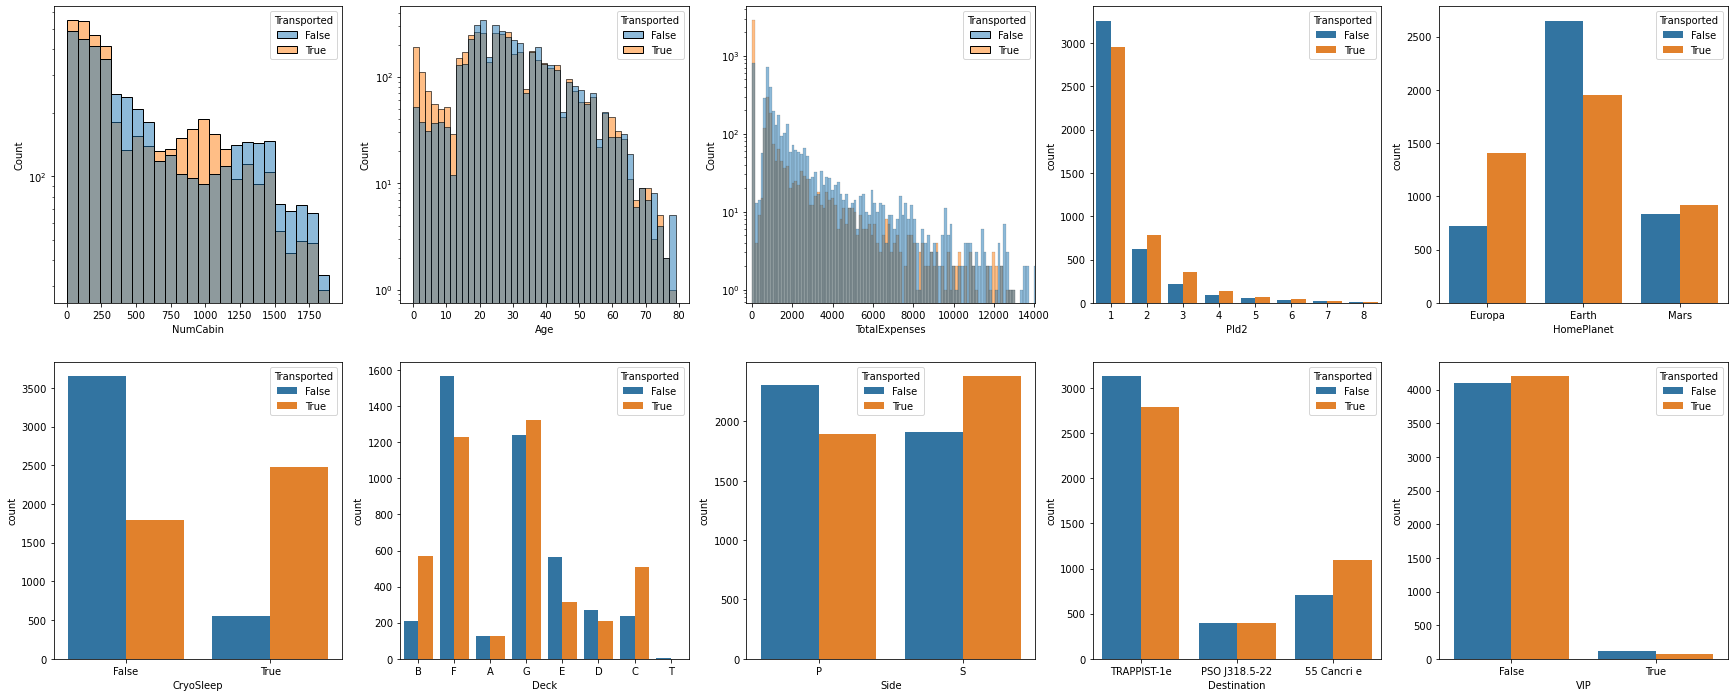

In [42]:
df = df_all[df_all['TrainOrTest']=='Train'].drop(
    axis=1,columns=['TrainOrTest', 'PId1', 'FirstName','LastName']
)
### Graphical display
plt.figure('Transported as hue', figsize=(5*6, 2*6)), plt.clf()
for i, col in enumerate(['NumCabin', 'Age', 'TotalExpenses']):
    axe1 = plt.subplot(2,5,i+1)
    sns.histplot(data=df, x=col, ax=axe1, log_scale=(False, True), hue='Transported', palette='tab10')
    if df[col].std()>1.5*df[col].mean() :
        axe1.set_xlim([-0.1*df_all[col].std(), 5*df_all[col].std()])
for i, col in enumerate(cat_col):
    axe1 = plt.subplot(2,5,i+4)
    sns.countplot(data=df, x=col, ax=axe1, hue='Transported', palette='tab10')
del i, col, axe1, df

###### 
### <u><b>I.D.2) Ordinal features distributions as a function of categorical features</b></u>


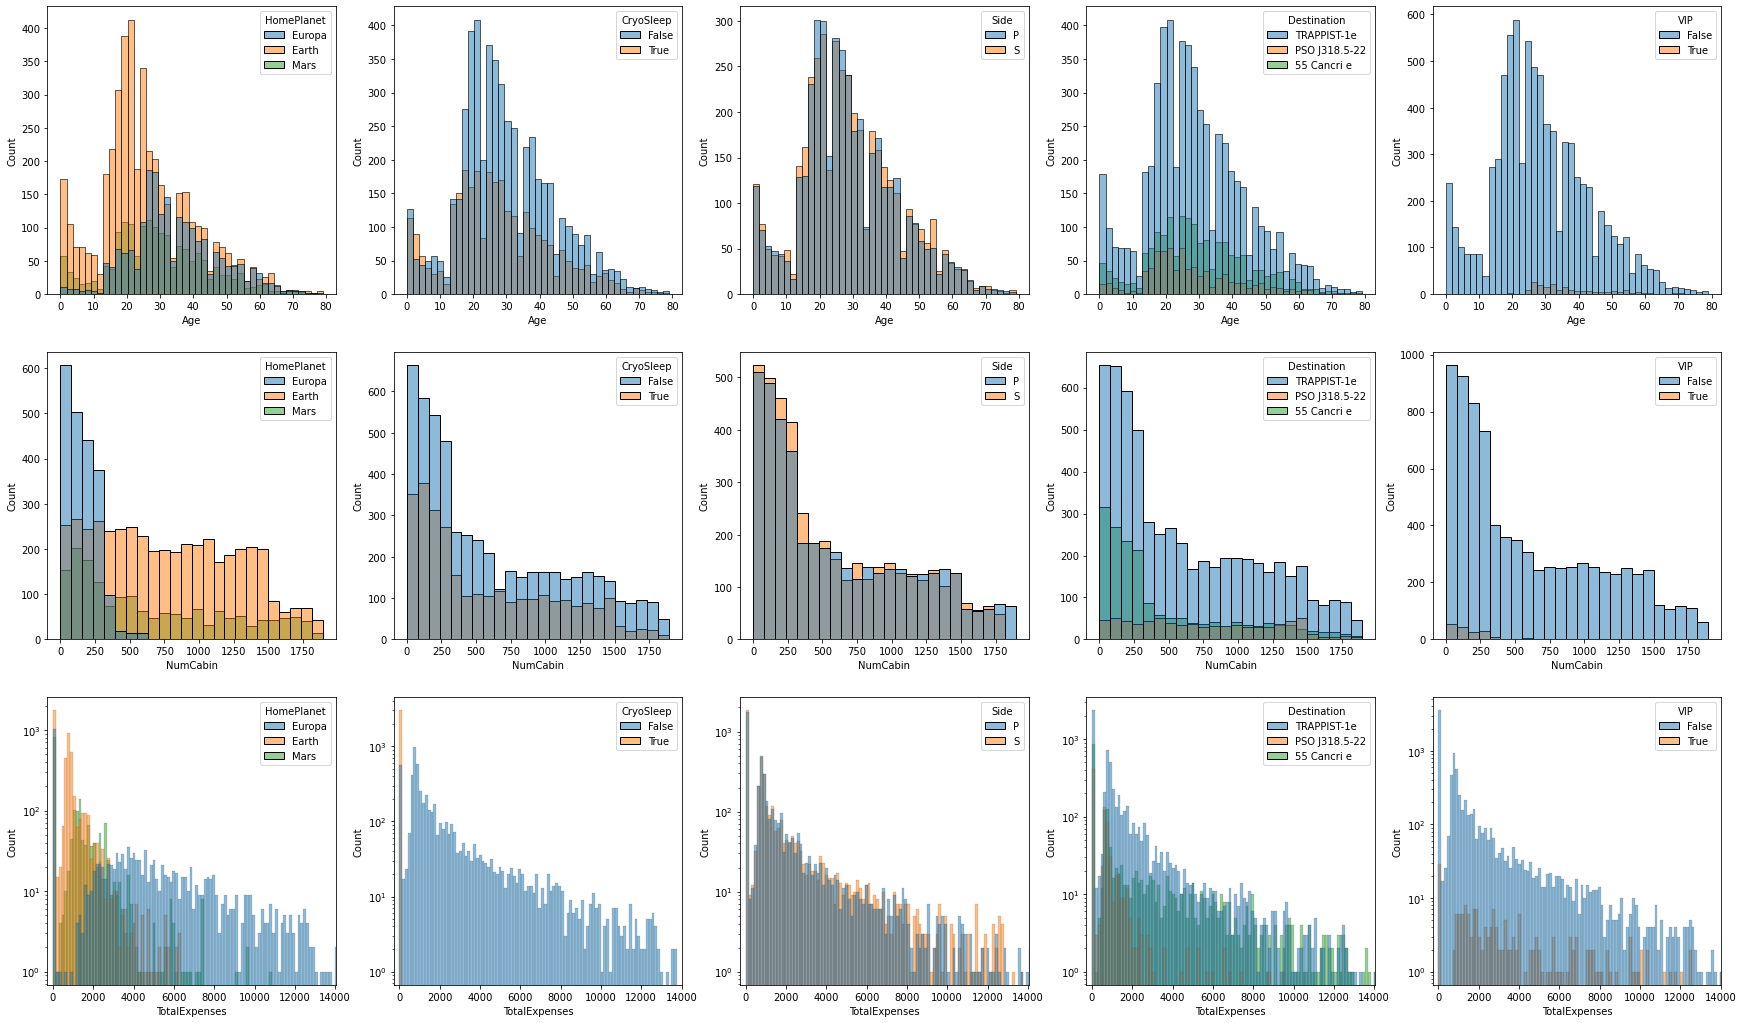

In [43]:
df = df_all[df_all['TrainOrTest']=='Train'].drop(
    axis=1,columns=['TrainOrTest', 'PId1', 'FirstName','LastName']
)
### Graphical display
plt.figure('MV EDA, num features - categorical hue - few number of cat', figsize=(5*6, 3*6)), plt.clf()
for i, col in enumerate(['Age', 'NumCabin', 'TotalExpenses']):#, 'RoomService', 'Spa', 'VRDeck']):
    logscale = (False, False) if i<2 else (False, True)
    for j, hue in enumerate(['HomePlanet', 'CryoSleep', 'Side', 'Destination', 'VIP']) :
        axe1 = plt.subplot(3,5,i*5+j+1)
        sns.histplot(data=df, x=col, ax=axe1, log_scale=logscale, hue=hue, palette='tab10')
        if i==2 :
            axe1.set_xlim([-0.1*df_all[col].std(), 5*df_all[col].std()])
del i, j, col, hue, axe1, logscale, df

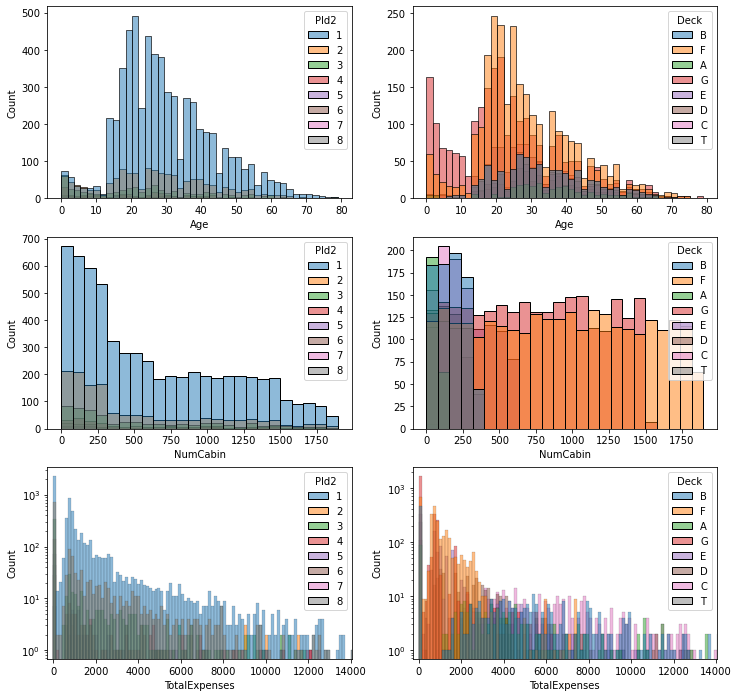

In [44]:
df = df_all[df_all['TrainOrTest']=='Train'].drop(
    axis=1,columns=['TrainOrTest', 'PId1', 'FirstName','LastName']
)
### Graphical display
plt.figure('MV EDA, num features - categorical hue - 8 number of cat', figsize=(3*4, 3*4)), plt.clf()
for i, col in enumerate(['Age', 'NumCabin', 'TotalExpenses']):#, 'RoomService', 'Spa', 'VRDeck']):
    logscale = (False, False) if i<2 else (False, True)
    for j, hue in enumerate(['PId2', 'Deck']) :
        axe1 = plt.subplot(3,2,i*2+j+1)
        sns.histplot(data=df, x=col, ax=axe1, log_scale=logscale, hue=hue, palette='tab10')
        if i==2 :
            axe1.set_xlim([-0.1*df_all[col].std(), 5*df_all[col].std()])        
del i, col, hue, axe1, logscale, df

###### 
### <u><b>I.D.3) Categorical features distributions as a function of categorical features</b></u>


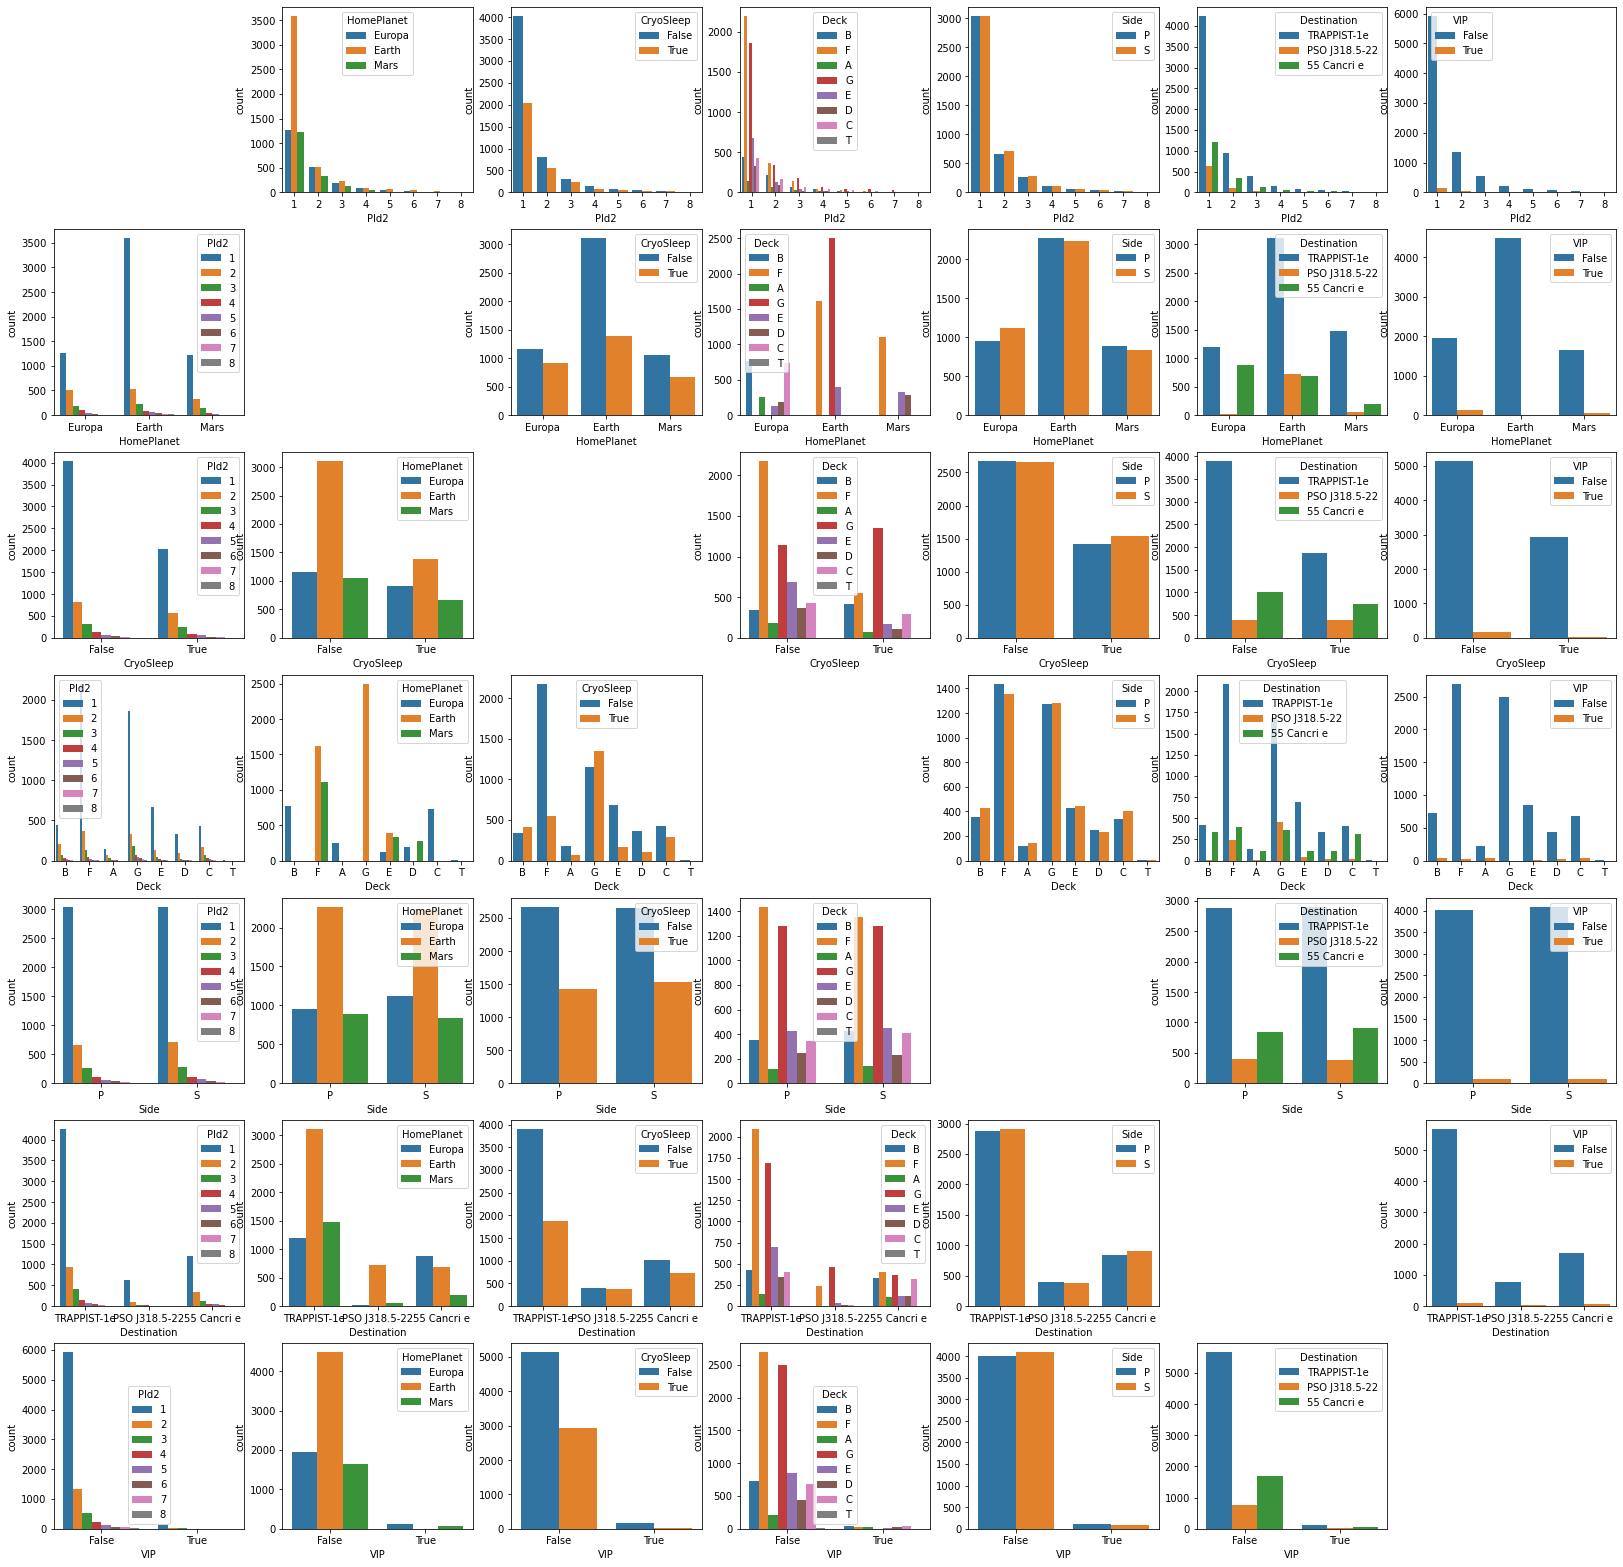

In [45]:
df = df_all[df_all['TrainOrTest']=='Train'].drop(
    axis=1,columns=['TrainOrTest', 'PId1', 'FirstName','LastName']
)
### Graphical display
plt.figure('Cat, cat hue', figsize=(4*len(cat_col), 4*len(cat_col))), plt.clf()
for i, col in enumerate(cat_col):
    for j, hue in enumerate(cat_col):
        axe1 = plt.subplot(len(cat_col),len(cat_col),i*len(cat_col)+j+1)
        if hue != col :
            sns.countplot(data=df, x=col, ax=axe1, hue=hue, palette='tab10')
        else :
            axe1.axis('off')
del i, j, col, hue, axe1, df

###### 
### <u><b>I.D.4) An accurated look taken at famillies of passengers.</b></u>


We noticed that a lot of passenger shared the same <i>LastName</i> value, infact, passengers without namesakes are quite rare...

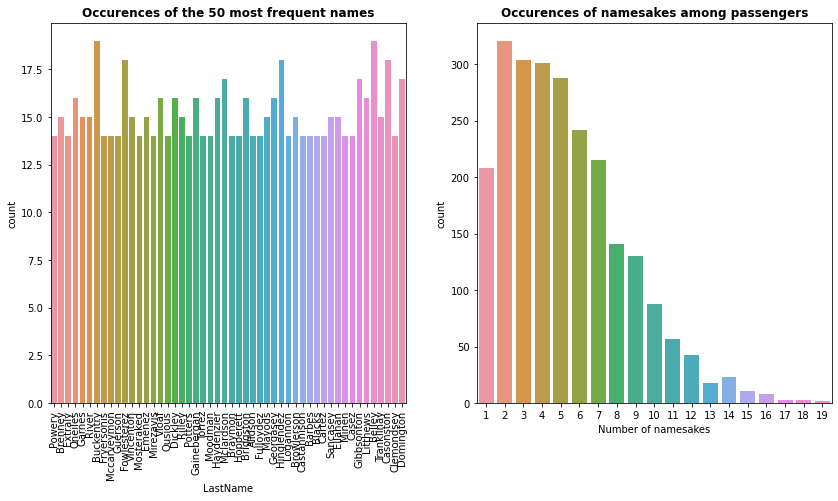

In [46]:
### Variables needed for graphical display
names_sup = df_all['LastName'].value_counts()[:50].index
df1 = df_all[df_all['LastName'].apply(lambda x : x in names_sup)]
df2 = df_all['LastName'].value_counts()
### Graphical display
plt.figure('Same lastnames', figsize=(14,7)), plt.clf()
axe1, axe2 = plt.subplot(121), plt.subplot(122)
# 50 most frequent names counting
sns.countplot(data=df1, x='LastName', ax=axe1)
axe1.set_xticklabels(labels=axe1.get_xticklabels(), fontdict={'rotation':90})
axe1.set_title('Occurences of the 50 most frequent names', weight='bold')
# Occurences of number of passenger with the same lastname
sns.countplot(data=df2, x=df2.index)
axe2.set_title('Occurences of namesakes among passengers', weight='bold')
axe2.set_xlabel('Number of namesakes')
del axe1, axe2, df1, df2, names_sup

That is to say : there should be famillies among passengers, and probably a lot of famillies.

Another proof of that would be the following statistics :

In [47]:
df_all.groupby(
    ['Deck','LastName','Side']
)['NumCabin'].value_counts().value_counts()

1    8419
2    1070
3     325
4     118
5      45
6      19
7       5
Name: NumCabin, dtype: int64

This means that more than 80% of passengers with the same <i>LastName</i> on the same <i>Deck</i> and the same <i>Side</i> DO SHARE THE SAME CABIN, hence high probability of theses passengers being members of the same famillies.Beyond this interpretation, this an important relationship between those 4 features, and we should keep it in mind when the time to fill missing values will come.

Another relationship of the same kind has been enlightened by XXX on the Kaggle discussion XXX. It shows that 1st part of <i>PassengerId</i> (<i>ie</i> our personnal column <i>PId1</i>) is quite correlated with <i>LastName</i>, more than 75% of passengers with the same <i>LastName</i> being also in the same group of <i>PId1</i> :

In [48]:
df_all.groupby(['PId1'])['LastName'].value_counts().value_counts()

1    7505
2    1339
3     450
4     139
5      54
6      30
7      15
8       4
Name: LastName, dtype: int64

A percentage which grows even bigger when <i>Deck</i> parameter is also taken into account :

In [49]:
df_all.groupby(['Deck','PId1'])['LastName'].describe()['unique'].value_counts()

1    9322
2     287
0     181
3      35
Name: unique, dtype: int64

And whose inverse is almost equivalent :

In [50]:
df_all.groupby(['LastName','PId1'])['Deck'].describe()['unique'].value_counts()

1    8753
2     591
0     170
3      22
Name: unique, dtype: int64

# 
# <u><b>II) Pre-processing datasets</b></u>
# 

## <u><b>II.A) Filling missing value</b></u> 
###### 


In [51]:
df_complete = df_all.copy(deep=True)

###### 
### <u><b>II.A.1) Most important feature : <i>CryoSleep</i>.</b></u>


In [52]:
print('Before filling missing values, there was %.0f NaN among CrySleep feature'%(df_complete['CryoSleep'].isna().sum()))

Before filling missing values, there was 310 NaN among CrySleep feature


Thanks to EDA, we saw that <i>CryoSleep</i> was highly absolute correlated with <i>Deck</i> and the luxury expenses features. 

Especialy, <i>CryoSleep</i>=True implies that the depenses are all null, and the inverse is really close to be true all the time :

In [53]:
df_all[
    (df_all['RoomService']==0)&(df_all['FoodCourt']==0)&(df_all['ShoppingMall']==0)&(df_all['Spa']==0)&(df_all['VRDeck']==0)
]['CryoSleep'].describe()

count     4735
unique       2
top       True
freq      4068
Name: CryoSleep, dtype: object

On the other hand, we saw that <i>Deck</i>=F or D or E highly increase the risk of not being cryoslept.

Thefore we decided to use this strategy to fill <i>CryoSleep</i> missing value :
- 1) if all luxury expenses are null, we put <i>CryoSleep</i>=True ; on the contrary, if any value among those five feature is > 0, then the put <i>CryoSleep</i>=False ;
- 2) if not, we pass the most frequent value of the corresponding kind of <i>Deck</i>.

In [54]:
### Passing False if any expenses is != 0 
indx = df_complete[
    (df_complete['TotalExpenses']>0)&(df_complete['CryoSleep'].isna())
].index
df_complete.loc[indx, 'CryoSleep'] = False
print('After this first round, it remains %.0f NaN among CrySleep feature'%(df_complete['CryoSleep'].isna().sum()))
del indx

After this first round, it remains 136 NaN among CrySleep feature


In [55]:
### Passing True if all expenses are = 0 
indx = df_complete[
    (df_complete['RoomService']==0)&(df_complete['FoodCourt']==0)&(df_complete['ShoppingMall']==0)&(df_complete['Spa']==0)&(df_complete['VRDeck']==0)&(df_complete['CryoSleep'].isna())
].index
df_complete.loc[indx, 'CryoSleep'] = True
print('After this first round (bis), it remains %.0f NaN among CrySleep feature'%(df_complete['CryoSleep'].isna().sum()))
del indx

After this first round (bis), it remains 13 NaN among CrySleep feature


In [56]:
indx = df_complete[df_complete['CryoSleep'].isna()].index
tops = df_complete.groupby('Deck')['CryoSleep'].describe()['top']
for i in list(indx):
    df_complete.loc[i, 'CryoSleep'] = tops[df_complete.loc[i, 'Deck']]
print('After this 2nd round, it remains %.0f NaN among CrySleep feature'%(df_complete['CryoSleep'].isna().sum()))
del indx, tops, i 

After this 2nd round, it remains 0 NaN among CrySleep feature


###### 
### <u><b>II.A.2) <i>Deck</i>, <i>NumCabin</i> and <i>Side</i></b></u>


In [57]:
print(
    'Before filling missing values, there was %.0f/%.0f/%.0f NaN among Deck/Cabin/Side feature'%(
        df_complete['Deck'].isna().sum(), 
        df_complete['NumCabin'].isna().sum(), 
        df_complete['Side'].isna().sum()
    )
)

Before filling missing values, there was 299/299/299 NaN among Deck/Cabin/Side feature


#### <u><b>First choice method :</b></u>

In [58]:
# Indexes where Deck/Num/Side are NaN
indx = df_all[pd.isna(df_all['Deck'])].index

In [59]:
for i in indx :
    id1 = df_all.loc[i,'PId1']
    if df_all[df_all['PId1']==id1].shape[0]>1 :
        d_c_s = df_all[
            df_all['PId1']==id1
        ][
            ['Deck', 'NumCabin', 'Side']
        ].dropna()#.drop_duplicates().values[0]
        if d_c_s.shape[0]>0 :
            d_c_s = d_c_s.drop_duplicates().values[0]
            df_complete.loc[i,['Deck','NumCabin','Side']] = d_c_s
        #[['Deck', 'NumCabin', 'Side']].dropna().drop_duplicates().values[0,0]
del i, id1, d_c_s

In [60]:
print(
    'After this 1st round of filling, it remains %.0f/%.0f/%.0f NaN among Deck/Cabin/Side feature'%(
        df_complete['Deck'].isna().sum(), 
        df_complete['NumCabin'].isna().sum(), 
        df_complete['Side'].isna().sum()
    )
)

After this 1st round of filling, it remains 162/162/162 NaN among Deck/Cabin/Side feature


#### <u><b>Second choice method :</b></u>

In [61]:
empty_dcs_byd = {}
for d in df_all['Deck'].dropna().unique() :
    # initialisation of list hich will contain vacant (deck,cabin,side) 
    list_dcs = []
    # maximum number of cabins by deck
    max_num = df_all[df_all['Deck']==d]['NumCabin'].max()+1
    for s in ['S','P']:
        # deck/cabin/side already taken
        taken_cabins = np.array(
            df_complete[
                df_complete['Deck']==d
            ][
                ['Side','NumCabin']
            ].value_counts().sort_index()[s].index
        )
        if len(taken_cabins) < max_num :#int(taken_cabins.max())+1 : 
            free_cabs = np.setxor1d(
                taken_cabins, np.arange(max_num)#taken_cabins.max()+1)
            )
            list_dcs.append([(d,cab,s) for cab in free_cabs])
    if len(list_dcs)>0 :
        empty_dcs_byd[d]=list(np.concatenate(list_dcs))
    else :
        empty_dcs_byd[d]=[]
del d, list_dcs, s, taken_cabins, free_cabs, max_num

In [62]:
# indexes of NaN for Deck AND not NaN for HomePlanet
indx = df_complete[
    (df_complete['Deck'].isna())&(df_complete['HomePlanet'].notna())
].index
# dictionnary : all decks possible for a given HomePlanet
decks_by_planet = {
    planet : list(
        df_complete.groupby('HomePlanet')['Deck'].value_counts()[planet].index
    ) for planet in df_all['HomePlanet'].unique() if pd.notna(planet)
}
# TotalExpenses means per kind of deck
totexps_by_deck = df_complete.groupby('Deck')['TotalExpenses'].median()

In [63]:
for i in list(indx):
    # We take HomePlanet's and TotalExpenses' values
    planet, totexp = (
        df_complete.loc[i, 'HomePlanet'], 
        df_complete.loc[i, 'TotalExpenses']
    )
    # Potential decks given the planet
    potential_decks = decks_by_planet[planet]
    # Deck whose TotalExpenses'median is the closest to TotalExpenses' curent value
    sorted_decks = list(totexps_by_deck[potential_decks].index[
        abs(totexps_by_deck[potential_decks].values-totexp).argsort()
    ])
    j = 0
    while len(empty_dcs_byd[sorted_decks[j]])==0 :
        j +=1
        if j == len(sorted_decks):
            break
    if j < len(sorted_decks) :
        df_complete.loc[i, ['Deck','NumCabin','Side']] = empty_dcs_byd[sorted_decks[j]].pop(-1)
del i, planet, totexp, potential_decks, sorted_decks, j 

In [64]:
print(
    'After this 2nd round of filling, it remains %.0f/%.0f/%.0f NaN among Deck/Cabin/Side feature'%(
        df_complete['Deck'].isna().sum(), 
        df_complete['NumCabin'].isna().sum(), 
        df_complete['Side'].isna().sum()
    )
)

After this 2nd round of filling, it remains 5/5/5 NaN among Deck/Cabin/Side feature


In [65]:
del decks_by_planet

#### <u><b>Third choice method :</b></u>

In [66]:
# indexes of NaN for Deck 
indx = df_complete[df_complete['Deck'].isna()].index
for i in list(indx):
    # We take TotalExpenses' value
    totexp = df_complete.loc[i, 'TotalExpenses']
    # Deck whose TotalExpenses'median is the closest to TotalExpenses' curent value
    sorted_decks = list(totexps_by_deck.index[
        abs(totexps_by_deck.values-totexp).argsort()
    ])
    j = 0
    while len(empty_dcs_byd[sorted_decks[j]])==0 :
        j +=1
        if j == len(sorted_decks):
            break
    if j < len(sorted_decks) :
        df_complete.loc[i, ['Deck','NumCabin','Side']] = empty_dcs_byd[sorted_decks[j]].pop(-1)
del i, totexp, sorted_decks, j

In [67]:
print(
    'After this 3rd round of filling, it remains %.0f/%.0f/%.0f NaN among Deck/Cabin/Side feature'%(
        df_complete['Deck'].isna().sum(), 
        df_complete['NumCabin'].isna().sum(), 
        df_complete['Side'].isna().sum()
    )
)

After this 3rd round of filling, it remains 0/0/0 NaN among Deck/Cabin/Side feature


In [68]:
del totexps_by_deck

###### 
### <u><b>II.A.3) Luxury expenses features.</b></u>


In [69]:
print('Before filling missing values, there was %.0f NaN among luxury expenses features'%(
    df_complete[
        ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    ].isna().sum().sum())
     )

Before filling missing values, there was 1410 NaN among luxury expenses features


For those featues, we already know that <i>CryoSleep</i>=True can be an easy way to fill NaN with 0, since we have shown that - logically - being cryoslept means spending no money. If we take a look at <i>CryoSleep</i> distribution for rows with at least one NaN among luxury expenses :

In [70]:
df_complete[
    (
        df_complete['RoomService'].isna()
    )|(
        df_complete['FoodCourt'].isna()
    )|(
        df_complete['ShoppingMall'].isna()
    )|(
        df_complete['Spa'].isna()
    )|(
        df_complete['VRDeck'].isna()
    )
]['CryoSleep'].value_counts()

False    842
True     521
Name: CryoSleep, dtype: int64

Well, there are 521 rows to fill easily with zeros. 

For the rest of rows corresponding to people with <i>CryoSleep</i>=False, we choose to use again the quite good correlation between those expenses and features such as <i>Deck</i> and/or <i>HomePlanet</i>, by passing the closest means per group (<i>Deck</i> , <i>HomePlanet</i>).

In [71]:
indx = df_complete[
    (
        df_complete['RoomService'].isna()
    )|(
        df_complete['FoodCourt'].isna()
    )|(
        df_complete['ShoppingMall'].isna()
    )|(
        df_complete['Spa'].isna()
    )|(
        df_complete['VRDeck'].isna()
    )
].index

#### <u><b>First choice method :</b></u>

In [72]:
indx1 = df_complete.loc[indx][df_complete.loc[indx,'CryoSleep']==True].index
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] :
    df_complete.loc[indx1, col] = 0
del  col

In [73]:
print(
    'After this 1st round of filling, it remains %.0f NaN among luxury expenses features'%(
        df_complete[
            ['RoomService', 
             'FoodCourt', 
             'ShoppingMall', 
             'Spa', 
             'VRDeck']
        ].isna().sum().sum()
    )
)

After this 1st round of filling, it remains 871 NaN among luxury expenses features


#### <u><b>Second choice method :</b></u>

In [74]:
indx2 = df_complete.loc[indx][df_complete.loc[indx,'CryoSleep']==False].index

In [75]:
# median expenses, by kind of deck
expenses_by_deck = df_complete.groupby(['Deck'])[
    ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
].median()
# median expenses, by group of (planet, deck)
expenses_by_planetdeck = df_complete.groupby(['HomePlanet','Deck'])[
    ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
].median()#.loc[('Earth','F')]

In [76]:
for i in list(indx2) :
    if pd.notna(df_complete.loc[i, 'HomePlanet']):
        df_complete.loc[
            i, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        ] = expenses_by_planetdeck.loc[
            (df_complete.loc[i, 'HomePlanet'], df_complete.loc[i, 'Deck'])
        ]
    else :
        df_complete.loc[
            i, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        ] = expenses_by_deck.loc[df_complete.loc[i, 'Deck']]
del i, indx2, expenses_by_deck, expenses_by_planetdeck

In [77]:
print(
    'After this 2nd round of filling, it remains %.0f NaN among luxury expenses features'%(
        df_complete[
            ['RoomService', 
             'FoodCourt', 
             'ShoppingMall', 
             'Spa', 
             'VRDeck']
        ].isna().sum().sum()
    )
)

After this 2nd round of filling, it remains 0 NaN among luxury expenses features


We can hereby re-calculate the sum of all those expenses (<i>ie</i> the parameter <i>TotalExpenses</i>), now that we have juts updated and filled all of the 5 columns used to calculate this parameter.

In [78]:
df_complete['TotalExpenses'] = df_complete[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

###### 
### <u><b>II.A.4) <i>HomePlanet</i> and <i>Destination</i></b></u>


#### <u><b><i>HomePlanet</i></b></u> 

In [79]:
print(
    'Before filling missing values, there was %.0f NaN among HomePlanet'%(
        df_complete['HomePlanet'].isna().sum().sum()
    )
)

Before filling missing values, there was 288 NaN among HomePlanet


Even if <i>HomePlanet</i> has a low average phiK correlation with the target <i>Transported</i>, it's an important paramter to fill missing value, due to its good correlations with a lot of other features.

Beside, <i>TotalExepenses</i> and <i>Deck</i>, whose correlations with <i>HomePlanet</i> are huge, are now completely filled (and update in the case of <i>TotalExepenses</i>). Thus, we have now the possibility to fill <i>HomePlanet</i>'s missing values in one single shot.

We will use a method similar to what we did previously : we will choose the planet corresponding to the group of (<i>Deck</i>, <i>HomePlanet</i>) whose <i>TotalExepenses</i>'s median is the closest of <i>TotalExepenses</i> curent taken value (the potential groups will be determined using <i>Deck</i> curent taken value)

In [80]:
# medians of each groups of (deck, planet)
totexp_by_deckplanet = df_complete.groupby(
    ['Deck','HomePlanet']
)['TotalExpenses'].median()
# indexes
indx = df_complete[df_complete['HomePlanet'].isna()].index
### Actual filling
for i in list(indx):
    # We take TotalExpenses' and Deck's curent values
    deck, totexp = (
        df_complete.loc[i, 'Deck'], 
        df_complete.loc[i, 'TotalExpenses']
    )
    # We create local variable : TotalExpenses' medians by planet, for a given deck
    totexp_planets = totexp_by_deckplanet.loc[deck]
    # Attribution of value instead of NaN
    df_complete.loc[i, 'HomePlanet'] = list(totexp_planets.index)[
        abs(totexp_planets.values-totexp).argmin()
    ]
print('After this 1st round of filling, it remains %.0f NaN among HomePLanet feature'%(df_complete['HomePlanet'].isna().sum()))
del i, totexp, deck, totexp_planets

After this 1st round of filling, it remains 0 NaN among HomePLanet feature


#### <u><b><i>Destination</i></b></u> 

In [81]:
print(
    'Before filling missing values, there was %.0f NaN among Destination'%(
        df_complete['Destination'].isna().sum().sum()
    )
)

Before filling missing values, there was 274 NaN among Destination


For the same reasons than before, we will use the same method again : we will choose the destination corresponding to the group of (<i>Deck</i>, <i>Destination</i>) whose <i>TotalExepenses</i>'s median is the closest of <i>TotalExepenses</i> curent taken value (the potential groups will be determined using <i>Deck</i> curent taken value)

In [82]:
# medians of each groups of (deck, planet)
totexp_by_deckplanet = df_complete.groupby(
    ['Deck','Destination']
)['TotalExpenses'].median()
# indexes
indx = df_complete[df_complete['Destination'].isna()].index
### Actual filling
for i in list(indx):
    # We take TotalExpenses' and Deck's curent values
    deck, totexp = (
        df_complete.loc[i, 'Deck'], 
        df_complete.loc[i, 'TotalExpenses']
    )
    # We create local variable : TotalExpenses' medians by planet, for a given deck
    totexp_planets = totexp_by_deckplanet.loc[deck]
    # Attribution of value instead of NaN
    df_complete.loc[i, 'Destination'] = list(totexp_planets.index)[
        abs(totexp_planets.values-totexp).argmin()
    ]
print('After this 1st round of filling, it remains %.0f NaN among Destination feature'%(df_complete['Destination'].isna().sum()))
del i, totexp, deck, totexp_planets

After this 1st round of filling, it remains 0 NaN among Destination feature


###### 
### <u><b>II.A.5) <i>Age</i></b></u>


In [83]:
from sklearn.impute import KNNImputer

In [84]:
kimp = KNNImputer(n_neighbors=10)

In [85]:
df_complete['Age'] = kimp.fit_transform(df_complete[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])[:,0]

In [86]:
print('After this 1st round of filling, it remains %.0f NaN among Age feature'%(df_complete['Age'].isna().sum()))

After this 1st round of filling, it remains 0 NaN among Age feature


###### 
### <u><b>II.A.6) <i>VIP</i></b></u>


In [87]:
indx = df_complete[df_complete['VIP'].isna()].index
df_complete.loc[indx, 'VIP'] = False

In [88]:
print('After this 1st round of filling, it remains %.0f NaN among VIP feature'%(df_complete['VIP'].isna().sum()))

After this 1st round of filling, it remains 0 NaN among VIP feature


In [89]:
df_complete

,PId1,PId2,HomePlanet,CryoSleep,Deck,NumCabin,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses,FirstName,LastName,Transported,TrainOrTest
0,1,1,Europa,False,B,0.0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Maham,Ofracculy,False,Train
1,2,1,Earth,False,F,0.0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,736.0,Juanna,Vines,True,Train
2,3,1,Europa,False,A,0.0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,10383.0,Altark,Susent,False,Train
3,3,2,Europa,False,A,0.0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,5176.0,Solam,Susent,False,Train
4,4,1,Earth,False,F,1.0,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1091.0,Willy,Santantines,True,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12969,9277,1,Earth,True,G,1498.0,S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Lilace,Leonzaley,NaN,Test
8689,9278,1,Earth,True,G,1499.0,S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,0.0,Kurta,Mondalley,False,Train
8690,9279,1,Earth,False,G,1500.0,S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,1873.0,Fayey,Connon,True,Train
8691,9280,1,Europa,False,E,608.0,S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,4637.0,Celeon,Hontichre,False,Train


######
## <u><b>II.B) Creating train and test sets.</b></u> 
###### 


### <u><b>II.B.1) Choosing our features</b></u>


#### <u><b>Re-calculating phi-k correlations.</b></u>

In [90]:
phik_corr_matrix = df_complete[df_complete['TrainOrTest']=='Train'].drop(
    axis=1,columns=['TrainOrTest', 'PId1', 'FirstName','LastName']
).phik_matrix().round(2)

interval columns not set, guessing: ['PId2', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalExpenses']


C:\Users\luked\anaconda3\envs\oc_iml_p5_01\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable NumCabin is large: 1907. Are you sure this is not an interval variable? Analysis for pairs of variables including NumCabin can be slow.
  warnings.warn(


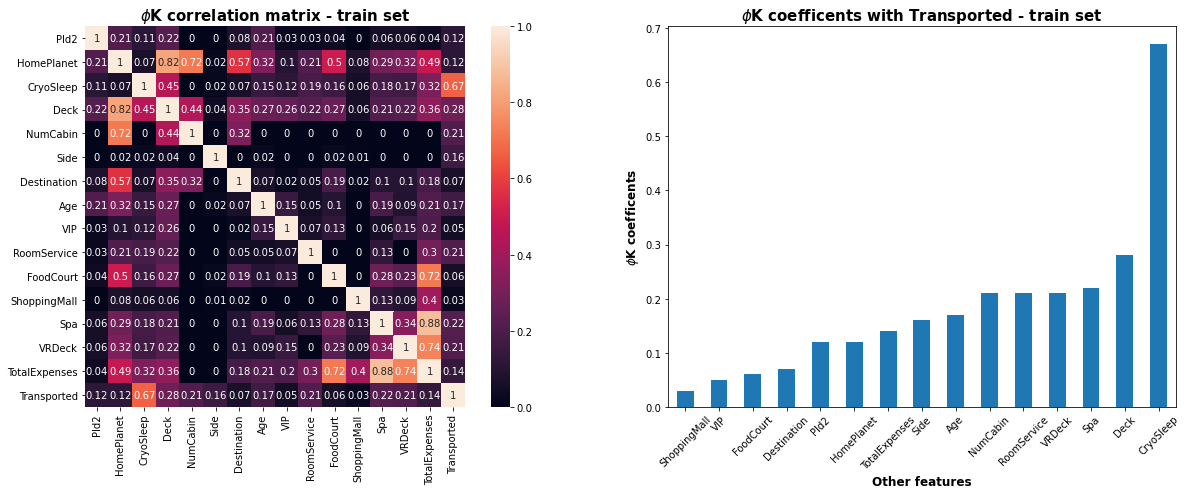

In [91]:
plt.figure('PhiK correlation coefficients - after filling missing values', figsize=(20,7)), plt.clf()
axe1, axe2 = plt.subplot(121), plt.subplot(122)
axe1.set_title(r'$\phi$K correlation matrix - train set', fontsize=15, fontweight='bold')
sns.heatmap(phik_corr_matrix, cbar=True, square=True, annot=True, ax=axe1)
axe2.set_title(r'$\phi$K coefficents with Transported - train set', fontsize=15, fontweight='bold')
axe2.set_ylabel(r'$\phi$K coefficents', fontsize=12, fontweight='bold'), axe2.set_xlabel('Other features', fontsize=12, fontweight='bold')
phik_corr_matrix['Transported'][:-1].sort_values().plot.bar(ax=axe2, rot=45)
del axe1, axe2

Filling missing values didn't change that much phi-k correlation coefficients between parameters. Thus, we can now use those values, and especially correlations coefficients with our taregt <i>Transported</i> to select most pertinent features.

#### <u><b>Actual features selection.</b></u>

Rather than selecting relevant features, it might be easier to exclude obviously irrelevant features.

For exemple, we don't take too many risks saying that <i>VIP</i>, taking almost every time the value False, and having a low phi-K correlation coefficient with our target. Therefore, we can legitimately decide to check <i>VIP</i> out of the relevant features list.

Due to the second reason that we have just risen, we can aslo check <i>ShoppingMall</i> out, its phi-K corr. coef. with our target being even smaller.

<i>FoodCourt</i> phi-K corr. coef. with <i>Transported</i> is barely better. Furthermore, <i>FoodCourt</i> is (just as <i>ShoppingMall</i> is) strongly correlated with <i>TotalExpenses</i>, whose phi-K corr. coef. with <i>Transported</i> is higher than the sum of <i>ShoppingMall</i> + <i>FoodCourt</i> coefficents. By saying this, we mean that if <i>ShoppingMall</i> and <i>FoodCourt</i> should have any influence on <i>Transported</i>, there is a solid probability that it expresses itsleft through <i>TotalExpenses</i>. Thus, we can check out <i>FoodCourt</i> without further delay.

The last parameter we can check out following that kind of logic would be <i>Destination</i>, its phi-K corr. coef. with <i>Transported</i> being barely better - again. 

We complete the list to cheked out parameters with <i>PId1</i>, <i>FirstName</i>, <i>LastName</i> (too much unique values, since they are identifiants rather than features)

In [92]:
features = df_complete.columns.copy(deep=True)
features = list(features.drop(['PId1', 'FirstName', 'Destination', 'VIP', 'FoodCourt', 'ShoppingMall', 'FirstName', 'LastName', 'Transported', 'TrainOrTest']))

######
### <u><b>II.B.2) Actual creating train and test sets.</b></u>


In [93]:
# list of indexes from train or test set
indxs = [df_complete.index[
    df_complete['TrainOrTest'].apply(lambda x : x==val)
] for val in ['Train', 'Test']]

In [94]:
# division of features matrix between train and test sets
X_train, X_test = [
    df_complete.loc[indx, features] for indx in indxs
]

In [95]:
# division of features matrix between train and test sets
y_train, y_test = [
    df_complete.loc[indx, 'Transported'] for indx in indxs
]

In [96]:
X_train

,PId2,HomePlanet,CryoSleep,Deck,NumCabin,Side,Age,RoomService,Spa,VRDeck,TotalExpenses
0,1,Europa,False,B,0.0,P,39.0,0.0,0.0,0.0,0.0
1,1,Earth,False,F,0.0,S,24.0,109.0,549.0,44.0,736.0
2,1,Europa,False,A,0.0,S,58.0,43.0,6715.0,49.0,10383.0
3,2,Europa,False,A,0.0,S,33.0,0.0,3329.0,193.0,5176.0
4,1,Earth,False,F,1.0,S,16.0,303.0,565.0,2.0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...
8688,1,Europa,False,A,98.0,P,41.0,0.0,1643.0,74.0,8536.0
8689,1,Earth,True,G,1499.0,S,18.0,0.0,0.0,0.0,0.0
8690,1,Earth,False,G,1500.0,S,26.0,0.0,1.0,0.0,1873.0
8691,1,Europa,False,E,608.0,S,32.0,0.0,353.0,3235.0,4637.0


######
## <u><b>II.C) Encoding and/or rescaling features.</b></u> 
###### 


### <u><b>II.C.1) Encoding labelled features</b></u>


#### <u><b>Label encoding</b></u>

In [97]:
deck_labenc = LabelEncoder()
deck_labenc.fit(X_train['Deck'])

LabelEncoder()

In [98]:
X_train['Deck'], X_test['Deck'] = [
    deck_labenc.transform(x) for x in [X_train['Deck'], X_test['Deck']]
]

#### <u><b>One hot encoding</b></u>

In [99]:
hp_ohe = OneHotEncoder(sparse=False)
hp_ohe.fit(X_train[['HomePlanet']])
train_ohe, test_ohe = [
    hp_ohe.transform(x[['HomePlanet']]) for x in [X_train, X_test]
]
for i, name in enumerate(hp_ohe.get_feature_names()):
    X_train.insert(1, name, train_ohe[:,i])
    X_test.insert(1, name, test_ohe[:,i])
del train_ohe, test_ohe, i, name
X_train.drop(columns='HomePlanet', inplace=True), X_test.drop(columns='HomePlanet', inplace=True)

(None, None)

In [100]:
print(
    'CryoSleep is now column n°', 
    np.arange(len(X_train.columns))[X_train.columns=='CryoSleep'][0]
)

CryoSleep is now column n° 4


In [101]:
cs_ohe = OneHotEncoder(sparse=False)
cs_ohe.fit(X_train[['CryoSleep']])
train_ohe, test_ohe = [
    cs_ohe.transform(x[['CryoSleep']]) for x in [X_train, X_test]
]
for i, name in enumerate(cs_ohe.get_feature_names()):
    X_train.insert(4, name, train_ohe[:,i])
    X_test.insert(4, name, test_ohe[:,i])
del train_ohe, test_ohe, i, name
X_train.drop(columns='CryoSleep', inplace=True), X_test.drop(columns='CryoSleep', inplace=True)

(None, None)

In [102]:
print(
    'Side is now column n°', 
    np.arange(len(X_train.columns))[X_train.columns=='Side'][0]
)

Side is now column n° 8


In [103]:
sp_ohe = OneHotEncoder(sparse=False)
sp_ohe.fit(X_train[['Side']])
train_ohe, test_ohe = [
    sp_ohe.transform(x[['Side']]) for x in [X_train, X_test]
]
for i, name in enumerate(sp_ohe.get_feature_names()):
    X_train.insert(4, name, train_ohe[:,i])
    X_test.insert(4, name, test_ohe[:,i])
del train_ohe, test_ohe, i, name
X_train.drop(columns='Side', inplace=True), X_test.drop(columns='Side', inplace=True)

(None, None)

###### 
### <u><b>II.C.2) Rescalling features</b></u>


#### <u><b>Visible impact of encoding on train set</b></u>

In [104]:
X_train

,PId2,x0_Mars,x0_Europa,x0_Earth,x0_S,x0_P,x0_True,x0_False,Deck,NumCabin,Age,RoomService,Spa,VRDeck,TotalExpenses
0,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,0.0,39.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5,0.0,24.0,109.0,549.0,44.0,736.0
2,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,58.0,43.0,6715.0,49.0,10383.0
3,2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,33.0,0.0,3329.0,193.0,5176.0
4,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5,1.0,16.0,303.0,565.0,2.0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,98.0,41.0,0.0,1643.0,74.0,8536.0
8689,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,6,1499.0,18.0,0.0,0.0,0.0,0.0
8690,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6,1500.0,26.0,0.0,1.0,0.0,1873.0
8691,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4,608.0,32.0,0.0,353.0,3235.0,4637.0


We have to explicitly convert <i>NumCabin</i>'s type into integer (less than hundred of its taken values were actually strings) :

In [105]:
print('We discovered that NumCain type was :',X_train['NumCabin'].dtype,', which means some values aren`t considered as float')
X_train['NumCabin'] = pd.to_numeric(X_train['NumCabin']).convert_dtypes(convert_integer=True)
print('Now, NumCain type has become :',X_train['NumCabin'].dtype)

We discovered that NumCain type was : object , which means some values aren`t considered as float
Now, NumCain type has become : Int64


Let's make a statistical description of the train set :

In [106]:
X_train.describe(percentiles=[])

,PId2,x0_Mars,x0_Europa,x0_Earth,x0_S,x0_P,x0_True,x0_False,Deck,NumCabin,Age,RoomService,Spa,VRDeck,TotalExpenses
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.00000,8693.000000,8693.000000,8693.000000,8693.000000
mean,1.517773,0.206488,0.250086,0.543426,0.501438,0.498562,0.360175,0.639825,4.295180,600.178419,28.82242,204.462211,284.843725,267.697400,1334.809272
std,1.054241,0.404808,0.433087,0.498139,0.500027,0.500027,0.480079,0.480079,1.782546,512.615884,14.35309,640.842415,1101.239148,1050.323772,2729.003490
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,425.000000,27.00000,0.000000,0.000000,0.000000,646.000000
max,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1894.000000,79.00000,14327.000000,22408.000000,20336.000000,35987.000000


It shows that there are huge differences between features, regarding if their come initially from categorical or ordinal features (before we did the encondings). 
Particullary, standard deviations and maxima differ drastically, which should warn us that this could lead to huge biaises during training phase, if we decided to give those values to the algorithm as inputs.

#### <u><b>Studying different scaling</b></u>

First, we draw displays of histograms of those features' univariate distributions, so that we can make comparisons with different scalings thereafter.

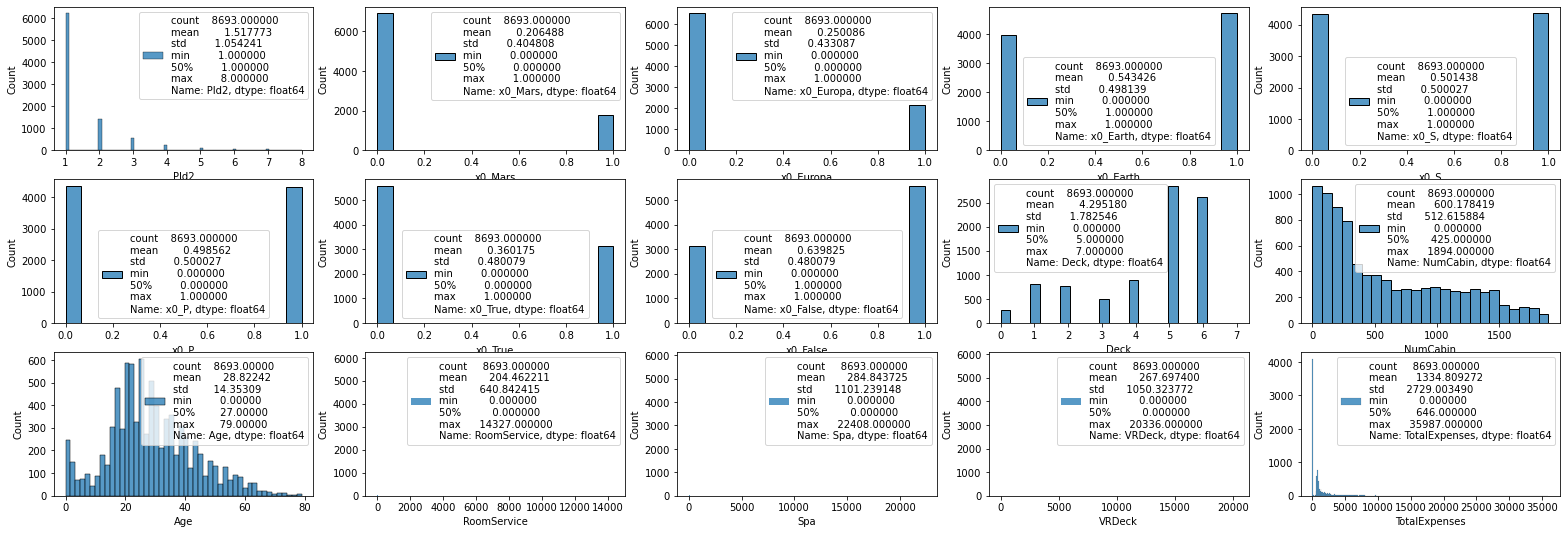

In [107]:
plt.figure('UV EDA, features after encoding', figsize=(27, 9)), plt.clf()
for i, col in enumerate(X_train.columns):
    axe1 = plt.subplot(3,5,i+1)
    sns.histplot(data=X_train, x=col, ax=axe1, label=str(X_train[col].describe(percentiles=[])))
    axe1.legend(loc='best', fontsize=10)
del i, col, axe1,

First kind of scaling that comes to our mind :
- 1) passing initially ordinal features to their log by using <i>np.log1p</i>, so that we can decrease the importance of outliers, and concentrate values in a range more narrow ;
- 2) passing all features through a <i>StandardScaler</i>, to equalize all standard deviations among features (we choose not to center them, so that all their values remain positive). 

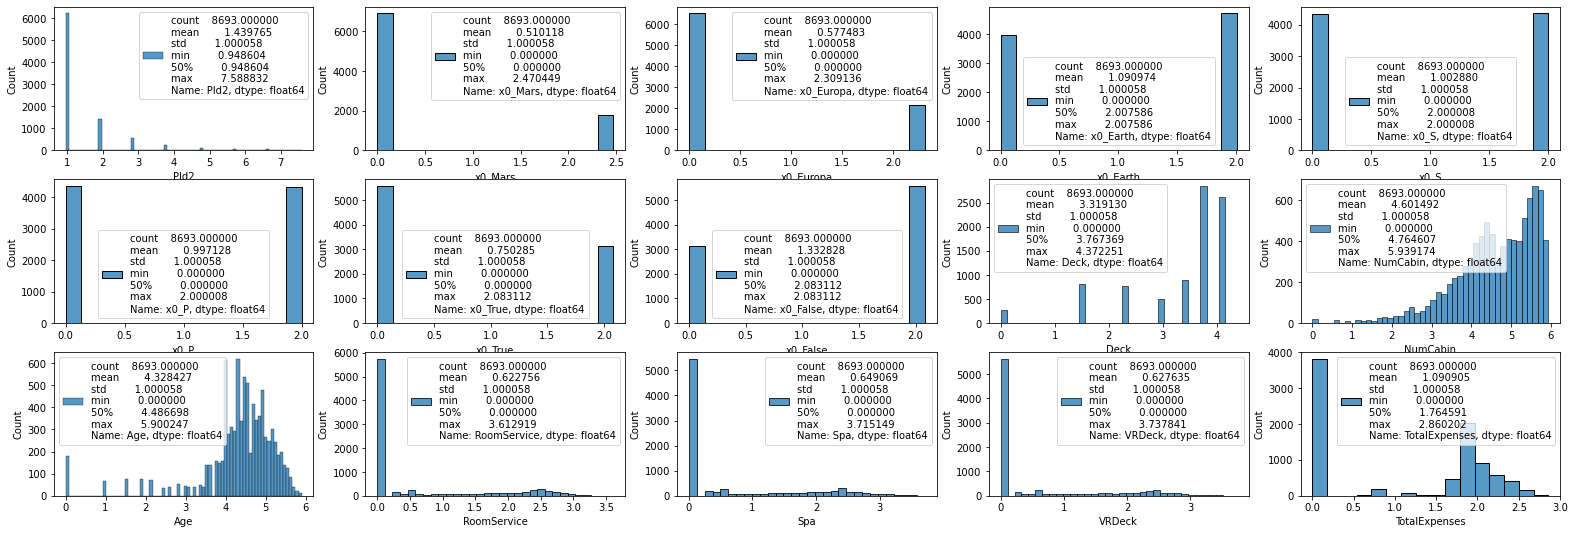

In [108]:
### Rescaling the train set with log1p and StandardScaler
df = X_train.copy(deep=True)
df[X_train.columns[-7:]] = df[X_train.columns[-7:]].apply(lambda x : np.log1p(x))
values = StandardScaler(with_mean=0).fit_transform(df)
df_ = pd.DataFrame(data={col : values[:,i] for i,col in enumerate(df.columns)}, index=df.index)
### Making a display
plt.figure('UV EDA, features after encoding + log1p + StdScale', figsize=(27, 9)), plt.clf()
for i, col in enumerate(X_train.columns):
    axe1 = plt.subplot(3,5,i+1)
    sns.histplot(data=df_, x=col, ax=axe1, label=str(df_[col].describe(percentiles=[])))
    axe1.legend(loc='best', fontsize=10)
del i, col, axe1, df, df_, values

It seems better, but even after this scaling, distributions from initially ordinal features still biases, oftenly due to the importance of '0' value.

Thus, we can also try a <i>QuantileTransformer</i> scaling :

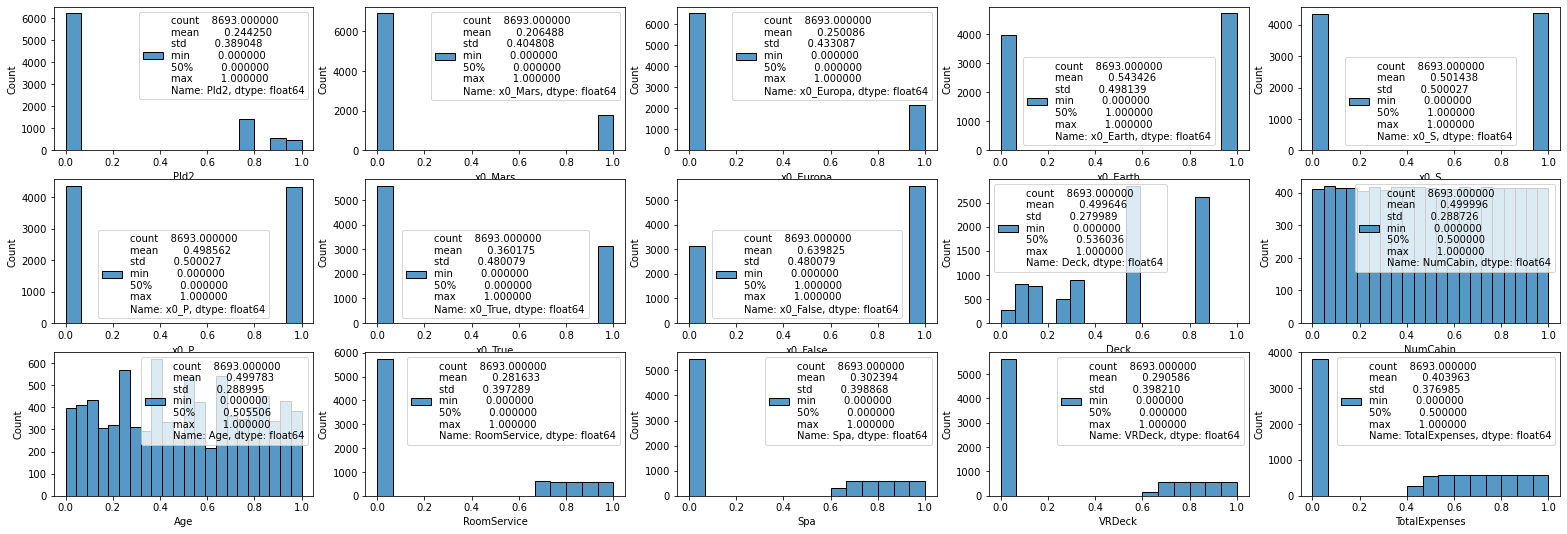

In [109]:
### Rescaling the train set with QuantileTransformer
df = X_train.copy(deep=True)
values = QuantileTransformer().fit_transform(df)
df_ = pd.DataFrame(data={col : values[:,i] for i,col in enumerate(df.columns)}, index=df.index)
### Graphical display
plt.figure('UV EDA, features after encoding + log1p + quantalietransfo', figsize=(27, 9)), plt.clf()
for i, col in enumerate(X_train.columns):
    axe1 = plt.subplot(3,5,i+1)
    sns.histplot(data=df_, x=col, ax=axe1, label=str(df_[col].describe(percentiles=[])))
    axe1.legend(loc='best', fontsize=10)
del i, col, axe1, df, df_, values

This scaling greatly reduced differences between distributions, all means and std being of the same order of magnitude, all maxima being stricly equal (we notice that it changes noting for initially categorical features that underwent one hot encoding)

#### <u><b>Putting different scaling to test</b></u>

We are going to challenge those 3 scalling (post encoding scaling, log1p + StandardScaling, and QuantileTransformer) through cross validating a simple logistic regression. We will put to test more complex algorithm in a near future of course, using logistic regression being just a way to produce a quite fast hyper-optimisation of hyper-parameters.

In [110]:
import warnings
warnings.filterwarnings(message="The max_iter was reached which means ", action='ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

1 ) With initial scaling (just after encoding categorical features) :

In [113]:
### Initilisation of models
logref = LogisticRegression(random_state=rgn)
grid = GridSearchCV(estimator=logref, 
                    param_grid={
                        'penalty':('l1','l2'), 
                        'C':np.logspace(-4, 1, 6), 
                        'solver':('liblinear', 'saga')
                    }, 
                    cv=5)
### cross validation and optimisation of hyper-parameters
grid.fit(X=X_train, y=y_train.apply(lambda x : str(x)))
grid.best_params_, grid.best_score_

({'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 0.7799391341001897)

2 ) With passing some features through their log1p, and with StandardScaling :

In [114]:
### Scaling train set
df = X_train.copy(deep=True)
df[X_train.columns[-7:]] = df[X_train.columns[-7:]].apply(lambda x : np.log1p(x))
values = StandardScaler(with_mean=0).fit_transform(df)
df = pd.DataFrame(data={col : values[:,i] for i,col in enumerate(df.columns)}, index=df.index)
### Initilisation of models
logref = LogisticRegression(random_state=rgn)
grid = GridSearchCV(estimator=logref, 
                    param_grid={
                        'penalty':('l1','l2'), 
                        'C':np.logspace(-4, 1, 6), 
                        'solver':('liblinear', 'saga')
                    }, 
                    cv=5)
### cross validation and optimisation of hyper-parameters
grid.fit(X=df, y=y_train.apply(lambda x : str(x)))
print(grid.best_params_, grid.best_score_)
del df, values

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 0.7636036741881073


3 ) With QuantileTransformer :

In [115]:
### Scaling train set
df = X_train.copy(deep=True)
values = QuantileTransformer().fit_transform(df)
df = pd.DataFrame(data={col : values[:,i] for i,col in enumerate(df.columns)}, index=df.index)
### Initilisation of models
logref = LogisticRegression(random_state=rgn)
grid = GridSearchCV(estimator=logref, 
                    param_grid={
                        'penalty':('l1','l2'), 
                        'C':np.logspace(-4, 1, 6), 
                        'solver':('liblinear', 'saga')
                    }, 
                    cv=5)
### cross validation and optimisation of hyper-parameters
grid.fit(X=df, y=y_train.apply(lambda x : str(x)))
print(grid.best_params_, grid.best_score_)
del df, values

{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'} 0.7372625300177146


It seems like it's better not using further scaling at all, at least with logistic regression. QuantileTransformer scaling leads to honorable scores, but clearly lower than initial scaling and log1p+StandardScaling, which is surprising, considering that logistic regression is sensitive to biaises (at least more than other more complex classifiers), whereas QuantileTransformer scaling was the most equalizing scaling of all.